In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from utils.ParamsCreator import (
    DataParams,
    LabelsParams,
    TimeseriesParams,
    ModelParams,
    ParamsParser
)

from utils.DataProcessor import DataProcessor, create_real_dict, adjust_indexes

from utils.ModelCreator import (
    create_model,
    train_model,
    prediction_n_step,
    forward_n_steps_ahead,
    sample_mc_dropout,
    model_mc_dropout
)

from utils.DataRetriever import load_npz

from utils.ResultDisplayer import plot_pred, plot_mcdropout, plot_config_prediction

from utils.utils import create_empty_dict

In [3]:
# Parameters for load data
data_params = DataParams(
    DATA_FOLDER="../../data/",
    IMGS_FOLDER="../../data/images/", 
    HEIGHT_ORIG=1080, 
    WIDTH_ORIG=1920, 
    HEIGHT=768, 
    WIDTH=1024
)

# Parameters for create labels
labels_params = LabelsParams(
    TRAIN_IMG_TYPE="natural", #natural, grey, black, inverted, white_noise, pink_noise, white
    TARGET_STEPS_AHEAD=1
)

# Parameters to create time series
timeseries_params = TimeseriesParams(
    SEQ_LENGTH=10 #200
)

# Parameters for learning
model_params = ModelParams(
    INPUT_UNITS=30, 
    LEARNING_RATE=0.0001, 
    EPOCHS=500,
    PATIENCE=15
)

params = ParamsParser(
    data_params,
    labels_params,
    timeseries_params,
    model_params,
    RESULTS_FOLDER="../results/sanity_checks/",  #"../results/MCDropout/", 
    CHECKPOINTS_FOLDER="../checkpoints/sanity_checks/",  #"../checkpoints/MCDropout/",
    N_MC_SAMPLES=30,
    is_train=True,
    is_save=True,
    is_save_figs=False,
    load_model=True
)

In [4]:
SUBJECT = "s605" #"s620"
N_STEPS_AHEAD = [1, 5, 11, 20]

# [$\checkmark$] Load data

In [5]:
# DataProcessor
data_processor = DataProcessor(SUBJECT, params)

# Load data
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data_processor.process(params.labels_params.TRAIN_IMG_TYPE)
scaler_x = data_processor.get_scaler()

print("X_train:", len(X_train), X_train[0].shape)
print("y_train:", len(y_train), y_train[0].shape)
print("X_val:", len(X_val), X_val[0].shape)
print("y_val:", len(y_val), y_val[0].shape)
print("X_test:", len(X_test), X_test[0].shape)
print("y_test:", len(y_test), y_test[0].shape)


X_train: 23 (1859, 10, 2)
y_train: 23 (1859, 2)
X_val: 11 (1843, 10, 2)
y_val: 11 (1843, 2)
X_test: 12 (1837, 10, 2)
y_test: 12 (1837, 2)


# [$\checkmark$] Load model

In [6]:
# Creating LSTM Model
lstm = create_model((X_train[0].shape[1], X_train[0].shape[2]), 
                    input_units=params.model_params.INPUT_UNITS, 
                    learning_rate=params.model_params.LEARNING_RATE
                   )
if params.load_model:
    params_name = params.get_params_name(SUBJECT, N_STEPS_AHEAD[0]) # Load model with N=1
    CHECKPOINT_FOLDER, _, CHECKPOINT_PATH = params.get_folders(params_name)
    if CHECKPOINT_PATH.split('/')[-1] in os.listdir(CHECKPOINT_FOLDER):
        lstm.load_weights(CHECKPOINT_PATH).expect_partial()
        print("Successfully load weights")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                3960      
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 6,882
Trainable params: 6,882
Non-trainable params: 0
______________________________________________________

# [$\checkmark$] Image test selection

In [7]:
# All images in test
img_test_names = data_processor.get_img_names()[-len(X_test):]

# Select ith image of test images
i_img = 0
img_test = img_test_names[i_img]

# [$\checkmark$] Check time series generator 

In [8]:
print(scaler_x.inverse_transform(X_test[i_img])[0])
print(y_test[i_img][0])

[[488.4 463.7]
 [489.2 461.6]
 [491.  458.5]
 [494.4 450.1]
 [499.9 437. ]
 [506.9 419.6]
 [514.5 399.7]
 [521.9 377.5]
 [528.2 352.9]
 [533.2 328.8]]
[536. 306.]


In [9]:
print(scaler_x.inverse_transform(X_test[i_img])[1])
print(y_test[i_img][1])

[[489.2 461.6]
 [491.  458.5]
 [494.4 450.1]
 [499.9 437. ]
 [506.9 419.6]
 [514.5 399.7]
 [521.9 377.5]
 [528.2 352.9]
 [533.2 328.8]
 [536.  306. ]]
[536.  287.2]


In [10]:
print(scaler_x.inverse_transform(X_test[i_img])[2])
print(y_test[i_img][2])

[[491.  458.5]
 [494.4 450.1]
 [499.9 437. ]
 [506.9 419.6]
 [514.5 399.7]
 [521.9 377.5]
 [528.2 352.9]
 [533.2 328.8]
 [536.  306. ]
 [536.  287.2]]
[533.3 271.4]


# [$\checkmark$] Check real data

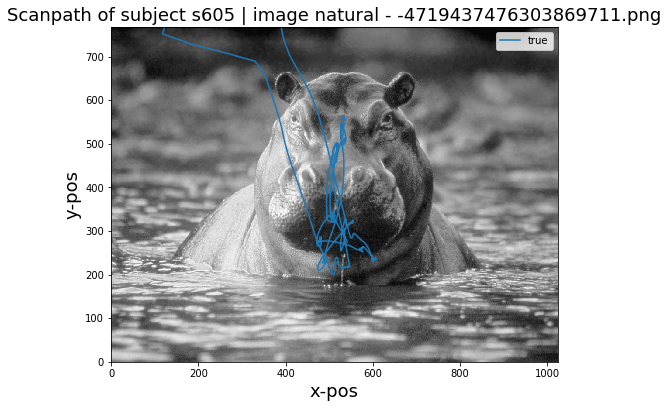

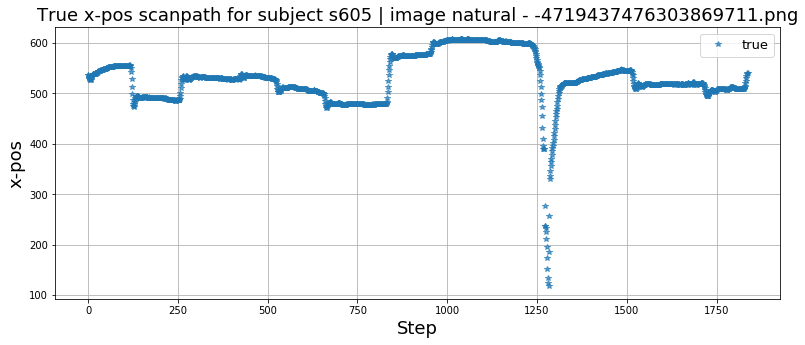

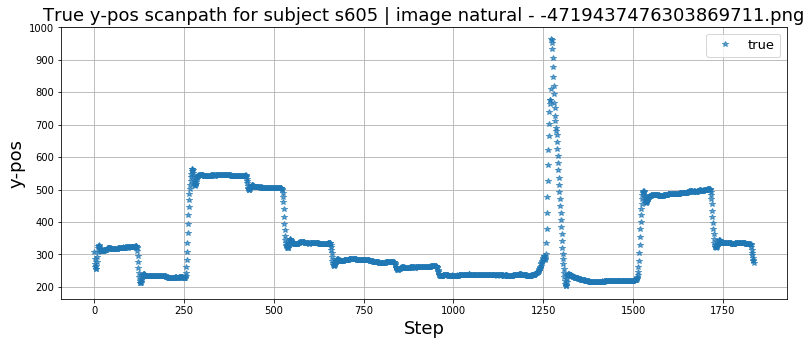

In [11]:
# Define x_lim for plot
x_lim = (None, None)

# Define y_real based on selected ith image
y_real = pd.DataFrame(y_test[i_img], columns=["x", "y"])

# Plot selected image and scanpath
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(0, params.data_params.WIDTH)
ax.set_ylim(0, params.data_params.HEIGHT)
line1, = ax.plot(0, 0)
line1.set_label("true")
line1.set_color("C0")  
plt.legend()
plt.title(f"Scanpath of subject {SUBJECT} | image {params.labels_params.TRAIN_IMG_TYPE} - {img_test}",fontsize=18)
plt.xlabel("x-pos", fontsize=18)
plt.ylabel("y-pos", fontsize=18)
img = np.flipud(plt.imread(f"{params.data_params.IMGS_FOLDER}/{img_test}"))
ax.imshow(img)
line1.set_xdata(y_real["x"][x_lim[0]:x_lim[1]])
line1.set_ydata(y_real["y"][x_lim[0]:x_lim[1]])

# Plot time-series
for x_or_y in ["x", "y"]:
    plt.figure(figsize=(13,5))
    plt.plot(y_real[x_or_y], 'C0*', label='true', alpha=0.7)
    plt.legend(loc='best', prop={'size': 13})
    plt.title(f'True {x_or_y}-pos scanpath for subject {SUBJECT} | image {params.labels_params.TRAIN_IMG_TYPE} - {img_test}', fontsize=18)
    plt.grid()
    plt.ylabel(f"{x_or_y}-pos", fontsize=18)
    plt.xlabel("Step", fontsize=18)
    plt.xlim(x_lim[0], x_lim[1])
    plt.show()

# [$\checkmark$] Check forward_n_steps_ahead

In [12]:
"""
Forward
"""
x_lim = (0,100) #(1245, 1290)

# One step starting at x_lim[0]
#X_test_i = np.expand_dims(X_test[i_img][x_lim[0]], 0)
X_test_i = X_test[i_img][x_lim[0]:x_lim[1]]

y_pred_list = forward_n_steps_ahead(
        X_test_i=X_test_i,  
        model=lstm, scaler=scaler_x, n_steps_ahead=N_STEPS_AHEAD)

In [13]:
y_pred_list[2]

{'i_step_ahead': 11, 'model_pred': array([[491.53995, 356.32422],
        [498.54764, 336.09036],
        [502.26193, 314.0705 ],
        [501.87363, 291.4882 ],
        [497.3296 , 269.95502],
        [489.31476, 250.84254],
        [479.44495, 235.60403],
        [470.03738, 225.21576],
        [463.67538, 220.32697],
        [461.5029 , 220.72548],
        [462.70346, 225.22916],
        [466.6012 , 232.61961],
        [472.1765 , 241.47237],
        [478.38895, 250.51117],
        [484.23123, 258.49118],
        [489.55386, 264.8093 ],
        [493.89215, 268.93378],
        [496.9308 , 270.8717 ],
        [498.78537, 271.06287],
        [499.51367, 270.0163 ],
        [499.33286, 268.25098],
        [498.61728, 266.29523],
        [497.70993, 264.46713],
        [496.87625, 262.94495],
        [496.26663, 261.81287],
        [495.93356, 261.0194 ],
        [495.8716 , 260.55353],
        [496.0743 , 260.34454],
        [496.47385, 260.31555],
        [497.0071 , 260.4089 ],
      

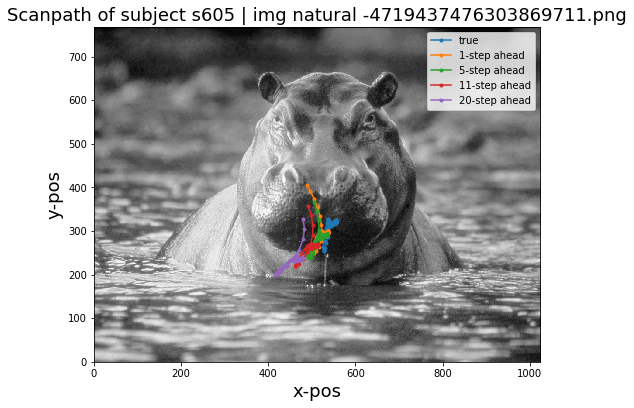

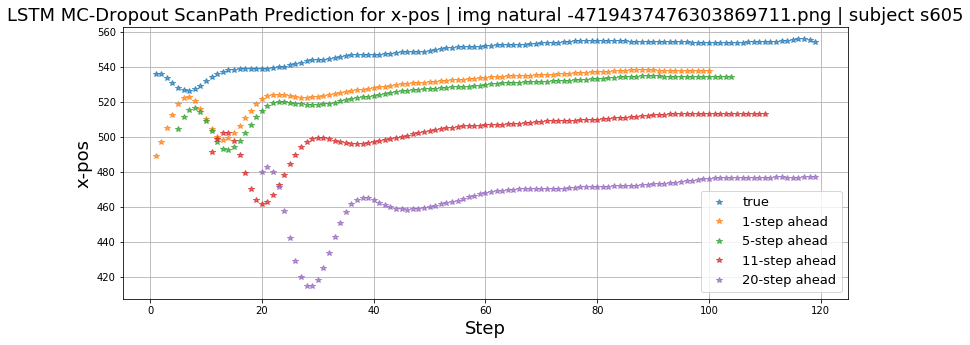

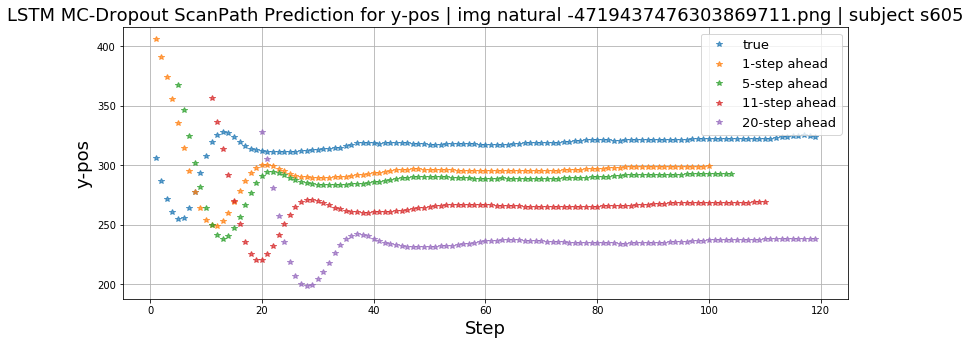

In [14]:
"""
Configuration
"""
# Config plot image
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(0, params.data_params.WIDTH)
ax.set_ylim(0, params.data_params.HEIGHT)
ax.set_title(f"Scanpath of subject {SUBJECT} | img {params.labels_params.TRAIN_IMG_TYPE} {img_test}", fontsize=18)
ax.set_xlabel("x-pos", fontsize=18)
ax.set_ylabel("y-pos", fontsize=18)
img = np.flipud(plt.imread(f"{params.data_params.IMGS_FOLDER}/{img_test}"))
ax.imshow(img)

title = 'LSTM MC-Dropout ScanPath Prediction for {}-pos | img {} {} | subject {}'
# Config plot timeseries x-pos
fig1, ax1 = plt.subplots(figsize=(13,5))
ax1.grid()
ax1.set_ylabel("x-pos", fontsize=18)
ax1.set_xlabel("Step", fontsize=18)

# Config plot timeseries y-pos
fig2, ax2 = plt.subplots(figsize=(13,5))
ax2.grid()
ax2.set_ylabel("y-pos", fontsize=18)
ax2.set_xlabel("Step", fontsize=18)

"""
Plots
"""
lines = [ax.plot(0,0)[0] for _ in range(len(N_STEPS_AHEAD)+1)]
for i, N_STEP in enumerate(N_STEPS_AHEAD):
    i_line = i + 1
    ## Define y_real and pred ##
    y_pred = pd.DataFrame(y_pred_list[i]["model_pred"], index=y_pred_list[i]["index"], columns=["x", "y"])
    y_real = pd.DataFrame(y_test[i_img][x_lim[0]:x_lim[1]+max(N_STEPS_AHEAD)-1], 
                          index=np.arange(1,len(y_test[i_img][x_lim[0]:x_lim[1]+max(N_STEPS_AHEAD)-1])+1),
                          columns=["x", "y"])
    
    assert y_pred_list[i]["i_step_ahead"] == N_STEP

    ## Plot image ##
    if i == 0:
        lines[0].set_label(f"true")
        lines[0].set_color("C0")  
        lines[0].set_xdata(y_real["x"])
        lines[0].set_ydata(y_real["y"])
        lines[0].set_marker(".")
    lines[i_line].set_label(f"{N_STEP}-step ahead")
    lines[i_line].set_color(f"C{i_line}") 
    lines[i_line].set_xdata(y_pred["x"])
    lines[i_line].set_ydata(y_pred["y"])
    lines[i_line].set_marker(".")
    

    ## Plot time-series (x-pos and y-pos) ##
    if i == 0:
        #ax1.plot(y_real["x"].index-timeseries_params.SEQ_LENGTH+1, y_real["x"], 'C0*', label='true', alpha=0.7)
        ax1.plot(y_real["x"], 'C0*', label='true', alpha=0.7)
        #ax2.plot(y_real["x"].index-timeseries_params.SEQ_LENGTH+1,y_real["y"], 'C0*', label='true', alpha=0.7)
        ax2.plot(y_real["y"], 'C0*', label='true', alpha=0.7)
    ax1.plot(y_pred["x"].index, y_pred["x"], f'C{i_line}*', label=f"{N_STEP}-step ahead", alpha=0.7)
    ax2.plot(y_pred["y"].index, y_pred["y"], f'C{i_line}*', label=f"{N_STEP}-step ahead", alpha=0.7)

"""
Configuration
"""    
ax.legend()
ax1.legend(loc='best', prop={'size': 13})
ax2.legend(loc='best', prop={'size': 13})
ax1.set_title(title.format("x", params.labels_params.TRAIN_IMG_TYPE, img_test, SUBJECT), fontsize=18)
ax2.set_title(title.format("y", params.labels_params.TRAIN_IMG_TYPE, img_test, SUBJECT), fontsize=18)
plt.show()

# [$\checkmark$] Create data for test

In [15]:
# Create artificial test
X_test_0 = X_test[0][x_lim[0]:x_lim[1]]
X_test_1 = X_test[1][x_lim[0]:x_lim[1]+1]
X_test_01 = [X_test_0, X_test_1]

y_test_0 = y_test[0][x_lim[0]:x_lim[1]]
y_test_1 = y_test[1][x_lim[0]:x_lim[1]]
y_test_01 = [y_test_0, y_test_1]

# [$\checkmark$] Check prediction_n_steps_ahead

In [16]:
y_pred_dict = prediction_n_step(
        X_test=X_test_01, 
        model=lstm, scaler=scaler_x, n_steps_ahead=N_STEPS_AHEAD)

Making prediction of image 1: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


In [17]:
y_real_dict = create_real_dict(y_real=y_test_01, n_steps_ahead=N_STEPS_AHEAD)

In [18]:
y_real_dict[11][0].head()

x      y
1  536.0  306.0
2  536.0  287.2
3  533.3  271.4
4  530.4  260.7
5  527.9  254.5

In [19]:
y_pred_dict[11][0].head()

x           y
11  491.539948  356.324219
12  498.547638  336.090363
13  502.261932  314.070496
14  501.873627  291.488190
15  497.329590  269.955017

# [$\checkmark$] Check Model MC Dropout

In [20]:
mcd_pred_dict, mcd_idxs_dict = sample_mc_dropout(
                model=lstm, 
                X_test=X_test_01, 
                scaler=scaler_x, 
                n_steps_ahead=N_STEPS_AHEAD, 
                #n_mc_samples=params.N_MC_SAMPLES
                n_mc_samples=3
            )

In [21]:
mcd_mean, mcd_std = model_mc_dropout(
                model=lstm, 
                X_test=X_test_01, 
                scaler=scaler_x, 
                n_steps_ahead=N_STEPS_AHEAD, 
                #n_mc_samples=params.N_MC_SAMPLES
                n_mc_samples=3
            )

# [$\checkmark$] Check how to compare real and pred

In [22]:
y_real_dict_new, y_pred_dict_new, mcdropout_mean_dict_new, mcdropout_std_dict_new = adjust_indexes(
    y_real_dict, 
    y_pred_dict, 
    n_steps_ahead=N_STEPS_AHEAD, 
    mcdropout_dicts=[mcd_mean, mcd_std])

In [23]:
y_real_dict[11][1].index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
             14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
             27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
             40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
             53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
             66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
             79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
             92,  93,  94,  95,  96,  97,  98,  99, 100],
           dtype='int64')

In [24]:
y_pred_dict[11][1].index

Int64Index([ 11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
            ...
            102, 103, 104, 105, 106, 107, 108, 109, 110, 111],
           dtype='int64', length=101)

In [25]:
y_real_dict_new[11][1].index

Int64Index([ 11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
             24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
             37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
             50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
             63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
             76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
             89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100],
           dtype='int64')

In [26]:
y_pred_dict_new[11][1].index

Int64Index([ 11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
             24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
             37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
             50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
             63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
             76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
             89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100],
           dtype='int64')

# [$\checkmark$] Check load results

In [27]:
y_pred

x           y
20   479.836090  327.735596
21   482.957672  305.270233
22   480.082245  281.149933
23   471.151276  257.361176
24   457.350555  235.945984
..          ...         ...
115  476.682922  237.888168
116  476.702881  237.945892
117  476.751221  238.057419
118  476.811310  238.213181
119  476.869904  238.370239

[100 rows x 2 columns]

===========> Working on natural images


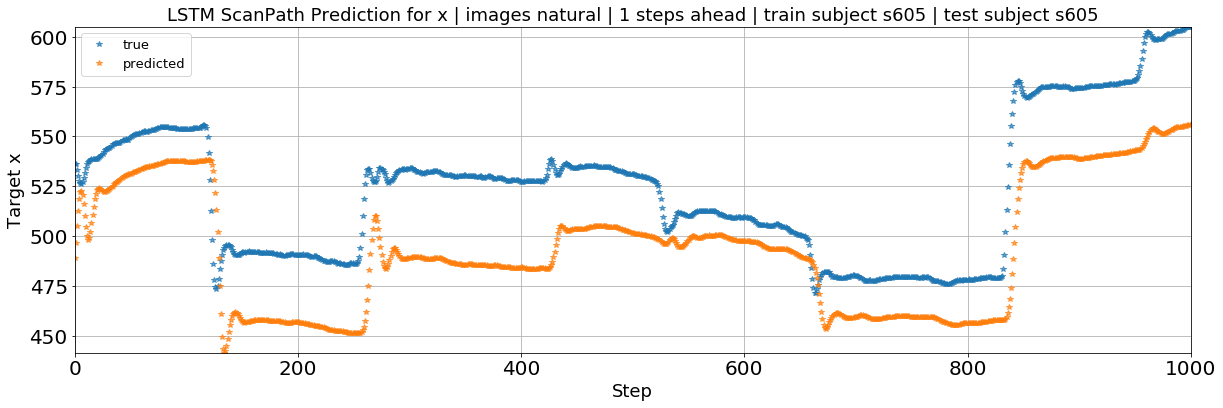

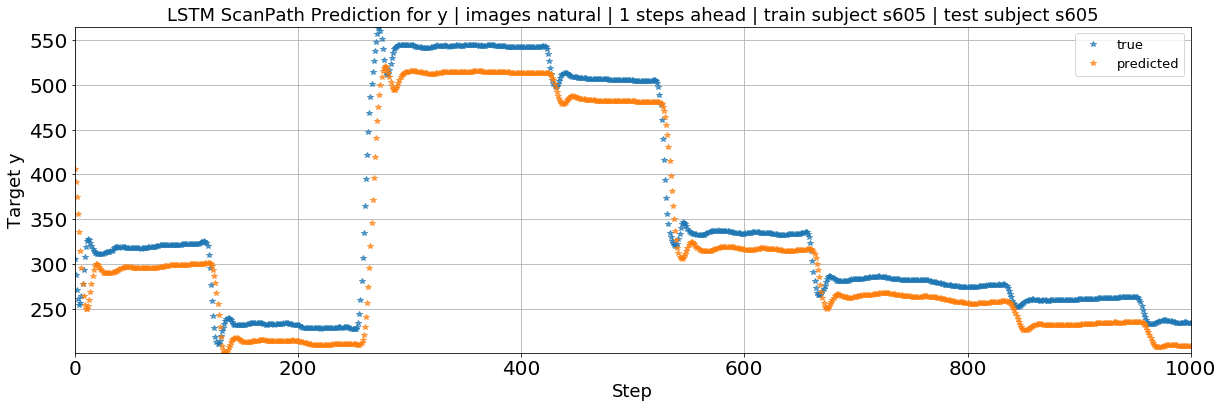

===========> Working on natural images


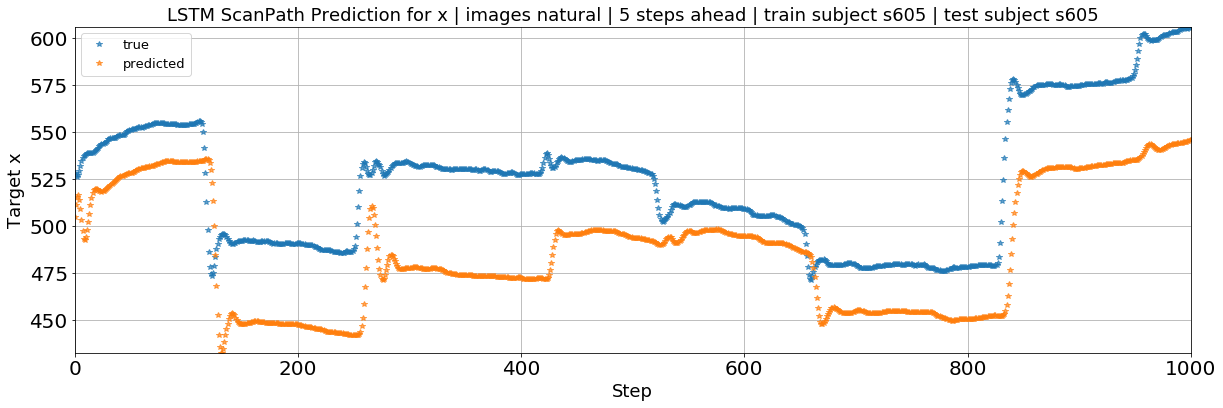

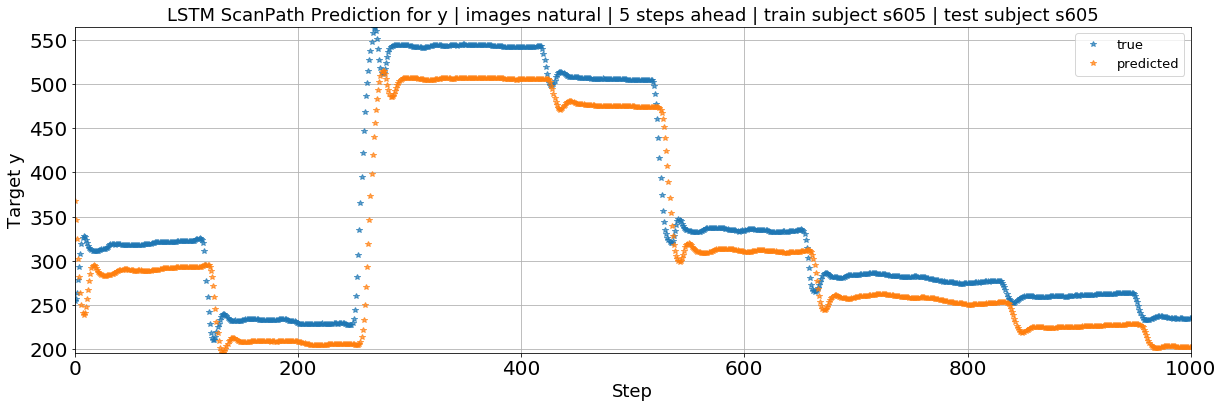

===========> Working on natural images


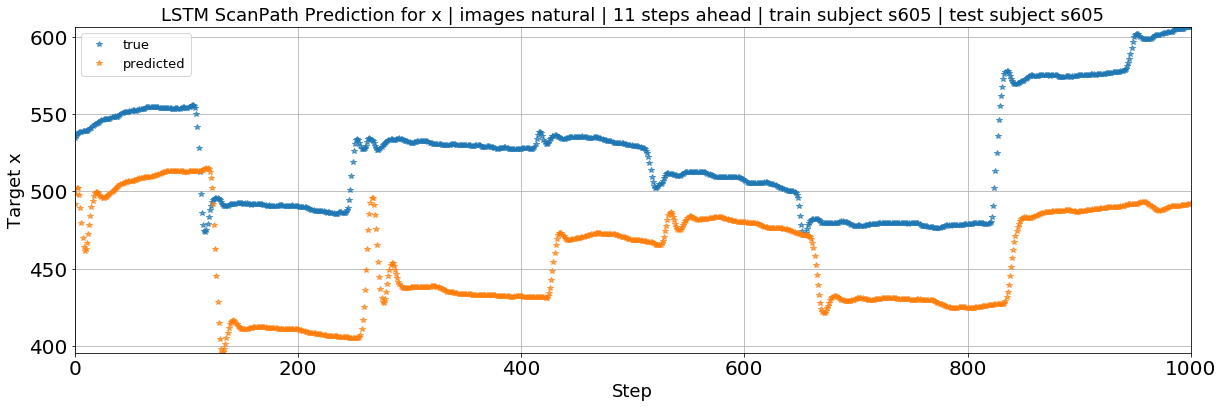

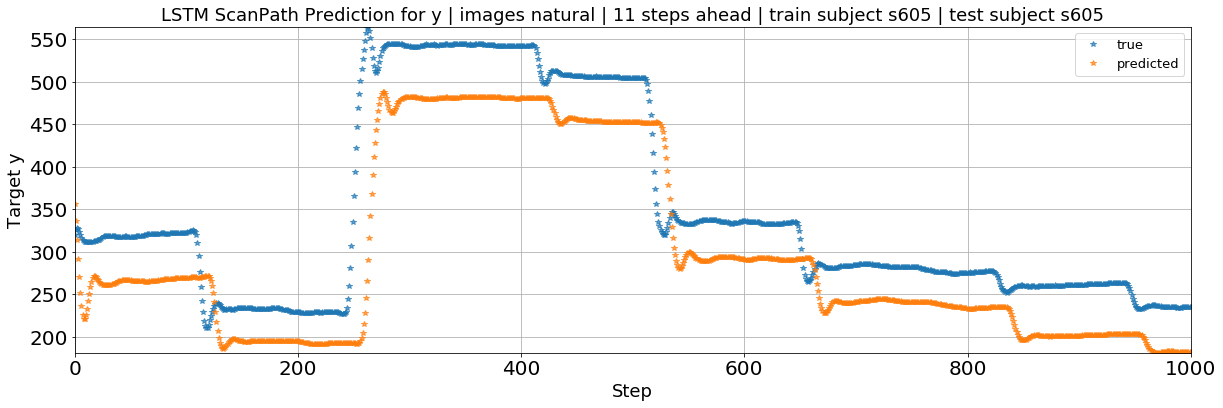

===========> Working on natural images


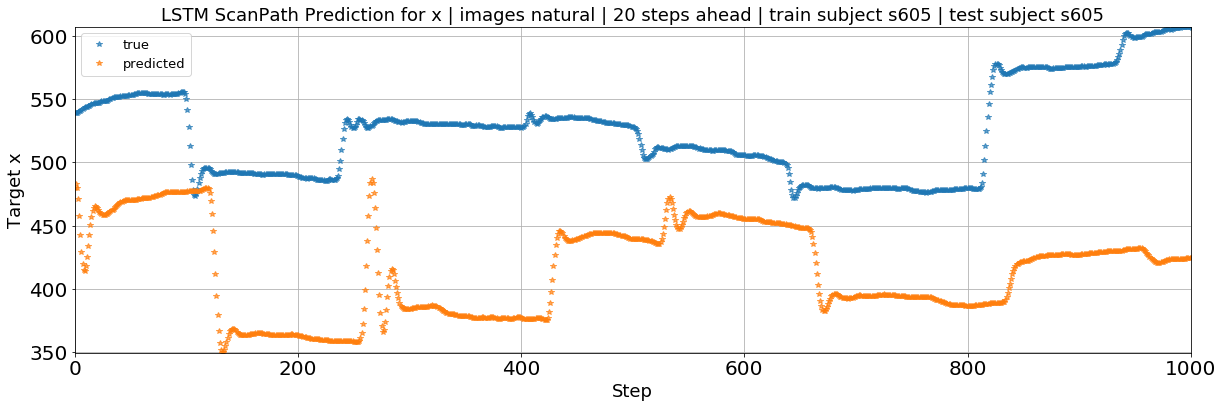

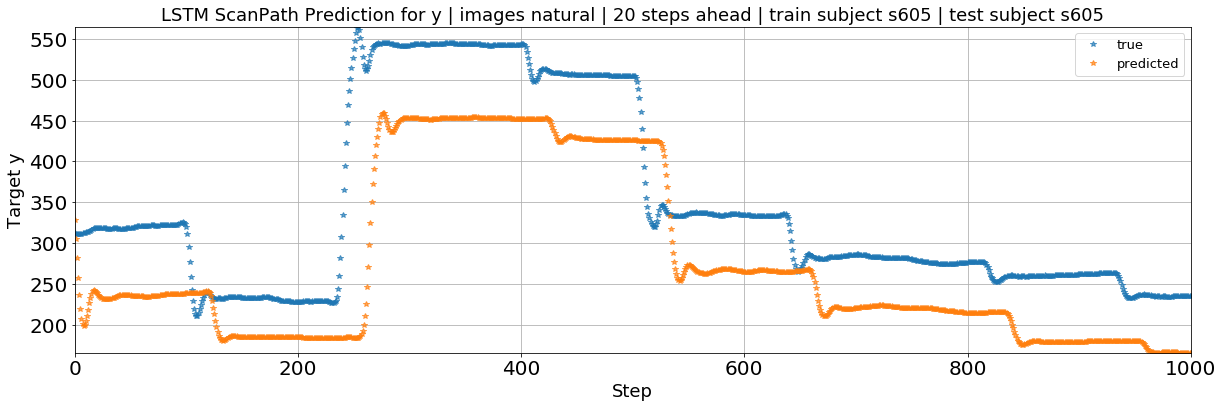

In [28]:
x_lim = (0, 1000)

# Params
for N in [1, 5, 11, 20]:
    Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15

    # Subjects
    subject_train = "s605" #s605, s617, s620

    # Test against themselves
    # -----------------------
    # Folders
    train_path = f"SUBJECT_{subject_train}-tIMG_natural-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

    folder_path_themselves = os.path.join(params.RESULTS_FOLDER,
                              train_path)
    # Load results
    y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                          "natural", 
                                                          get_mcdropout_results=True)
    y_real.reset_index(inplace=True)
    y_pred.reset_index(inplace=True)
    mcdropout_mean.reset_index(inplace=True)
    mcdropout_std.reset_index(inplace=True)
    
    # Plot
    for x_or_y in ["x", "y"]:
        #plot_mcdropout(y_real, y_pred, mcdropout_mean, mcdropout_std, x_or_y)
        plot_pred(y_real, y_pred, x_or_y)
        plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
        plt.ylim(
            min(min(y_real[x_or_y].loc[x_lim[0]:x_lim[1]]), min(y_pred[x_or_y].loc[x_lim[0]:x_lim[1]])),
            max(max(y_real[x_or_y].loc[x_lim[0]:x_lim[1]]), max(y_pred[x_or_y].loc[x_lim[0]:x_lim[1]]))
        )
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.show()

===========> Working on natural images


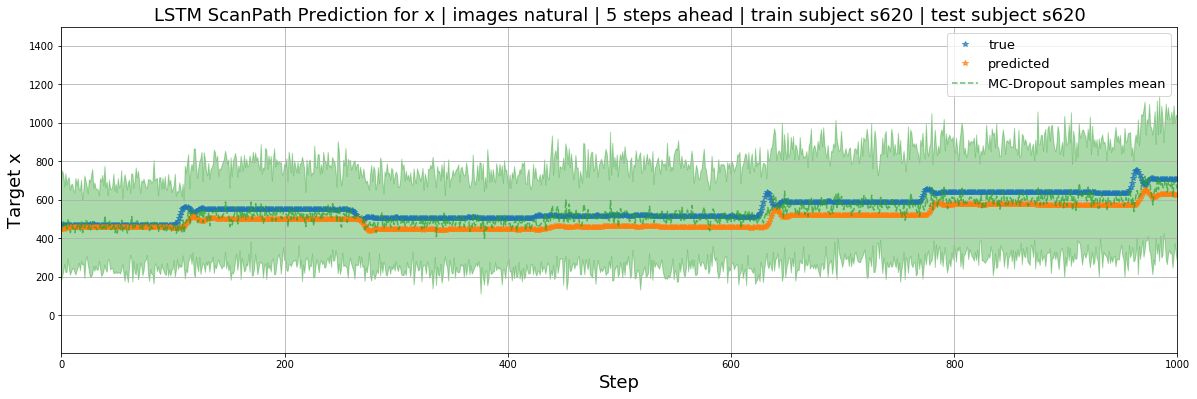

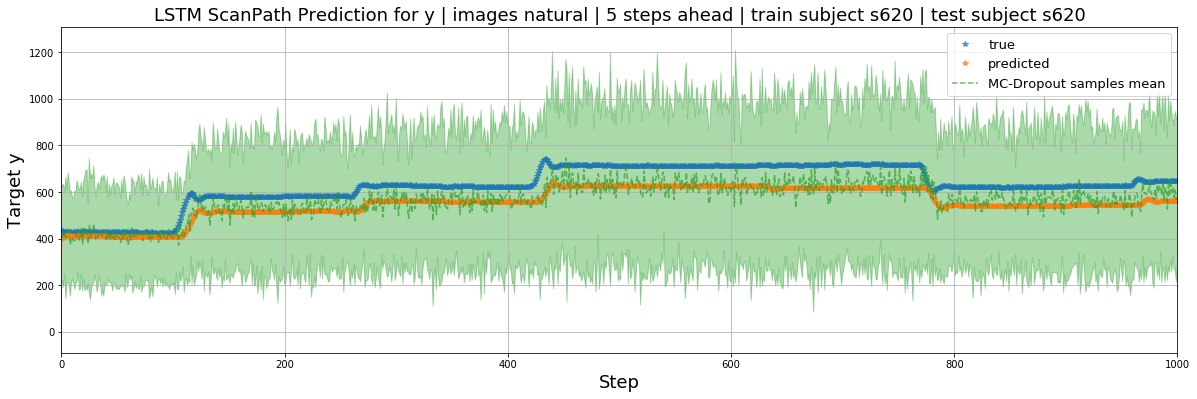

===========> Working on natural images


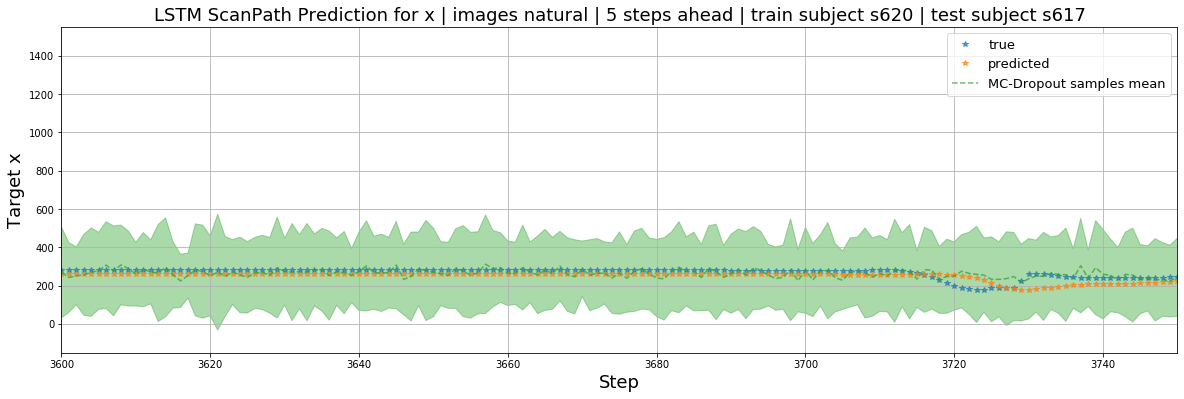

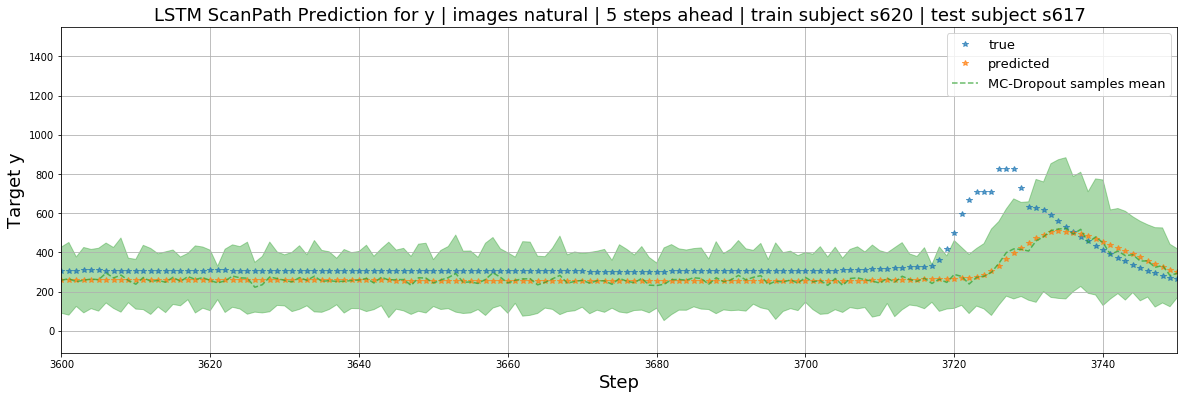

In [29]:
# Params
N = 5
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15

# Subjects
subject_train = "s620" #s605, s617, s620
subject_test = "s617"

# Test against themselves
# -----------------------
# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_natural-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(params.RESULTS_FOLDER,
                          train_path)
# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      "natural", 
                                                      get_mcdropout_results=True)
y_real.reset_index(inplace=True)
y_pred.reset_index(inplace=True)
mcdropout_mean.reset_index(inplace=True)
mcdropout_std.reset_index(inplace=True)
# Plot
for x_or_y in ["x", "y"]:
    plot_mcdropout(y_real, y_pred, mcdropout_mean, mcdropout_std, x_or_y)
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=(0,1000))#(5400,5460))#(3600, 3750))
    plt.show()

# Test against other
# -------------------
# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_natural-N_{1}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"
test_path = f"SUBJECT_{subject_test}-tIMG_natural-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_others = os.path.join(params.RESULTS_FOLDER,
                          train_path,
                           "all_vs_all",
                          test_path)
# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_others, 
                                                      "natural", 
                                                      get_mcdropout_results=True)
y_real.reset_index(inplace=True)
y_pred.reset_index(inplace=True)
mcdropout_mean.reset_index(inplace=True)
mcdropout_std.reset_index(inplace=True)
# Plot
for x_or_y in ["x", "y"]:
    plot_mcdropout(y_real, y_pred, mcdropout_mean, mcdropout_std, x_or_y)
    plot_config_prediction(x_or_y, subject_train, subject_test, N=N, x_lim=(3600, 3750))
    plt.show()

# [X] Check duration multimatch metric

In [30]:
import multimatch_gaze as m
from utils.MetricsCalculator import calculate_multimatch
# Params
N = 11
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15

tIMG = "natural"
predIMG = "natural"

# Subject
subject_train = "s620" #s605, s617, s620

# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(params.RESULTS_FOLDER,
                          train_path)

## Test eyeBehaviour

In [31]:
def format_output_eyeBehaviour(events):
    tpoSac = events[0]
    tpoFix = events[1]
    # Saccade events
    columns_sac = ["t_i", "t_f", "Asac", "diff_t", "start_x", "start_y", "end_x", "end_y", "blink_flag"]
    df_sac = pd.DataFrame(tpoSac, columns=columns_sac)
    df_sac["duration"] = df_sac["diff_t"]*0.002
    df_sac_start = df_sac[["start_x", "start_y", "duration", "t_i"]]
    df_sac_end = df_sac[["end_x", "end_y", "duration", "t_f"]]
    df_sac_end.columns = ["start_x", "start_y", "duration", "t_i"]
    df_sac_formatted = pd.concat([df_sac_start, df_sac_end]).sort_values("t_i")
    df_sac_formatted = df_sac[["start_x", "start_y", "duration", "t_i"]]
    # Fixation events
    columns_fix = ["t_i", "t_f", "diff_t", "start_x", "start_y", "blink_flag"]
    df_fix = pd.DataFrame(tpoFix, columns=columns_fix)
    df_fix["duration"] = df_fix["diff_t"]*0.002
    df_fix_formatted = df_fix[["start_x", "start_y", "duration", "t_i"]]
    return df_sac_formatted, df_fix_formatted

In [32]:
from utils.MetricsCalculator import eyeBehaviour#, format_output_eyeBehaviour
import json

# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)
mcdropout_mean.reset_index(inplace=True, drop=True)
mcdropout_std.reset_index(inplace=True, drop=True)

# Test eye Behaviour
idx = np.expand_dims(np.arange(len(y_pred)), -1)
y_real_eye = np.concatenate([idx, y_real], axis=1)
y_pred_eye = np.concatenate([idx, y_pred], axis=1)
events_real = eyeBehaviour(y_real_eye)
events_pred = eyeBehaviour(y_pred_eye)
sac_real, fix_real = format_output_eyeBehaviour(events_real)
sac_pred, fix_pred = format_output_eyeBehaviour(events_pred)

# Plot
y_real_plot = y_real.copy()
y_pred_plot = y_pred.copy()
y_real_plot.index = (idx*0.002).squeeze()
y_pred_plot.index = (idx*0.002).squeeze()

===========> Working on natural images


In [33]:
sac_real["type"] = "SAC"
fix_real["type"] = "FIX"
df_path_real = pd.concat([sac_real, fix_real]).sort_values("t_i")
df_path_real

sac_pred["type"] = "SAC"
fix_pred["type"] = "FIX"
df_path_pred = pd.concat([sac_pred, fix_pred]).sort_values("t_i")
df_path_pred

start_x     start_y  duration      t_i type
0    448.331940  392.917389     0.064    107.0  SAC
0    474.053070  481.079529     0.250    140.0  FIX
1    470.406891  481.032135     0.036    266.0  SAC
1    405.925842  526.025208     0.002    285.0  FIX
2    405.246582  525.801453     0.012    287.0  SAC
..          ...         ...       ...      ...  ...
165  647.654968  305.643524     0.286  21751.0  FIX
219  644.382141  305.706329     0.028  21895.0  SAC
220  643.584534  296.306305     0.008  21911.0  SAC
166  639.188599  296.680237     0.136  21916.0  FIX
221  636.335571  296.650360     0.068  21985.0  SAC

[389 rows x 5 columns]

In [34]:
df_path_real["type"].shape

(405,)

In [35]:
df_path_pred["type"].shape

(389,)

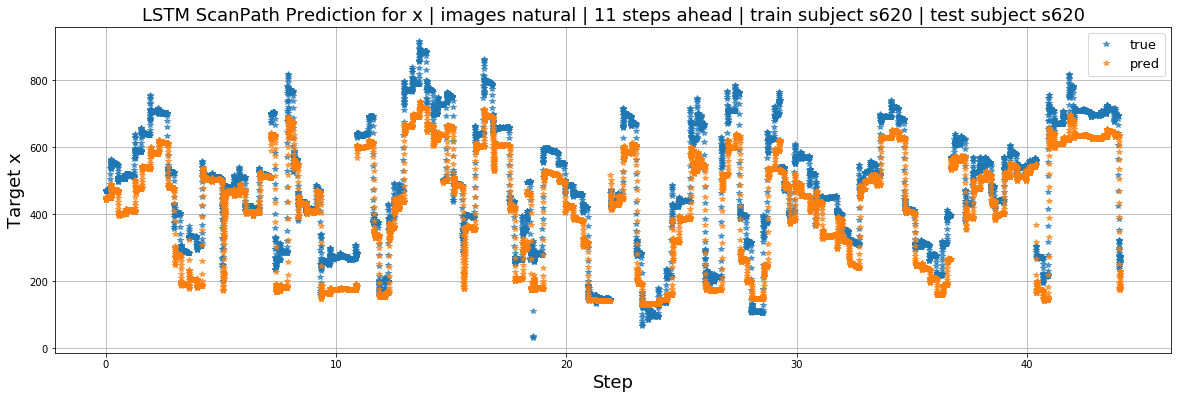

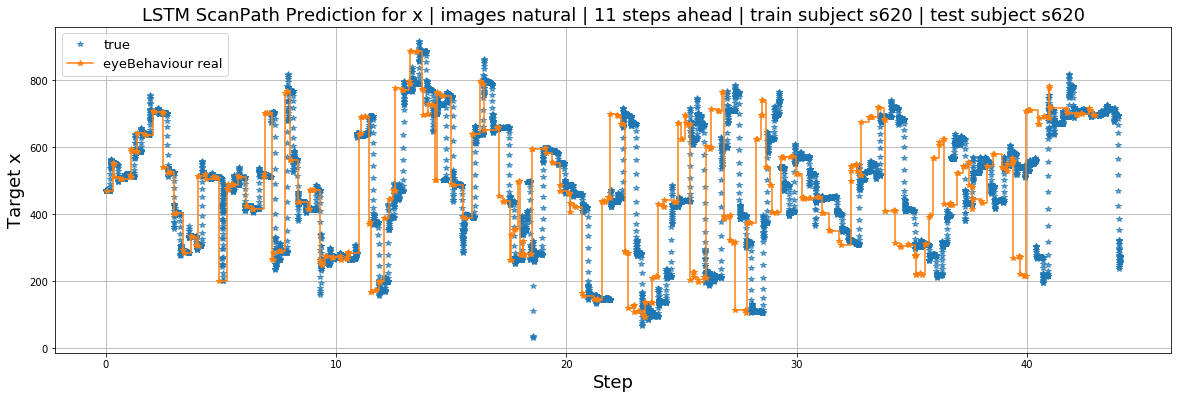

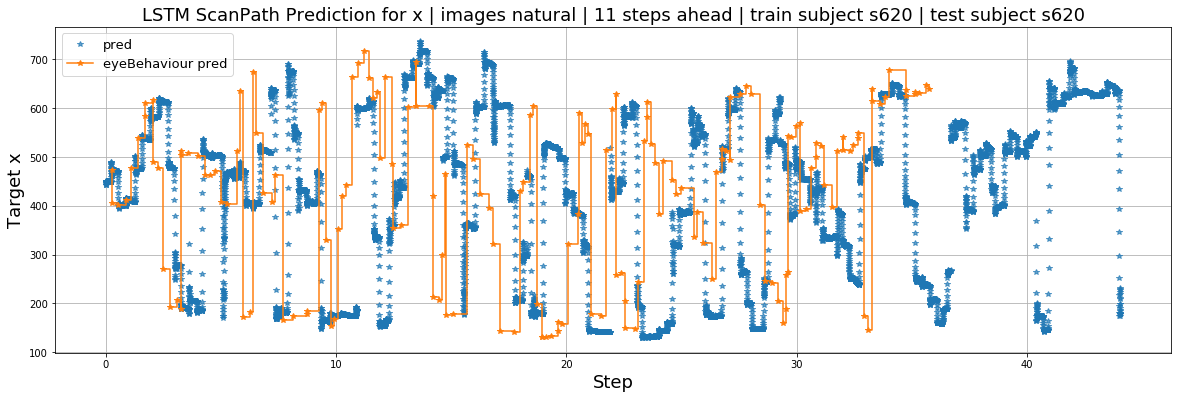

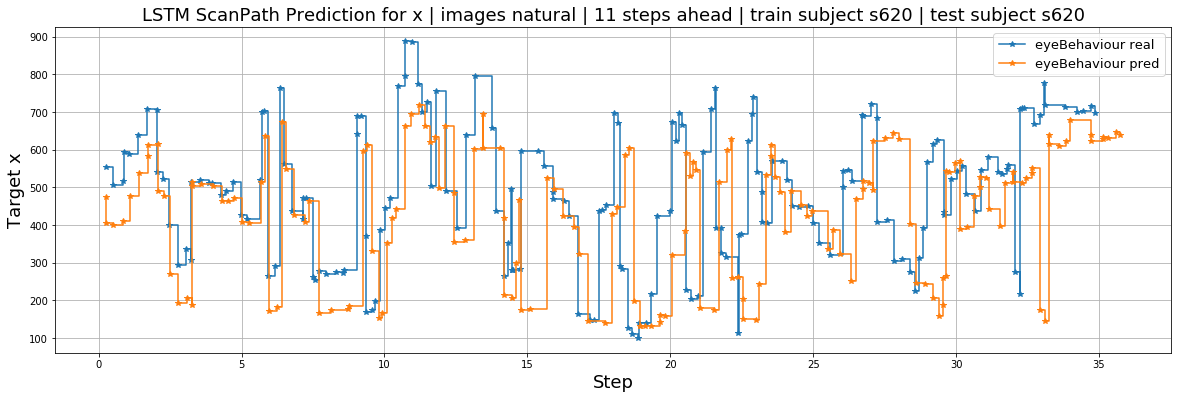

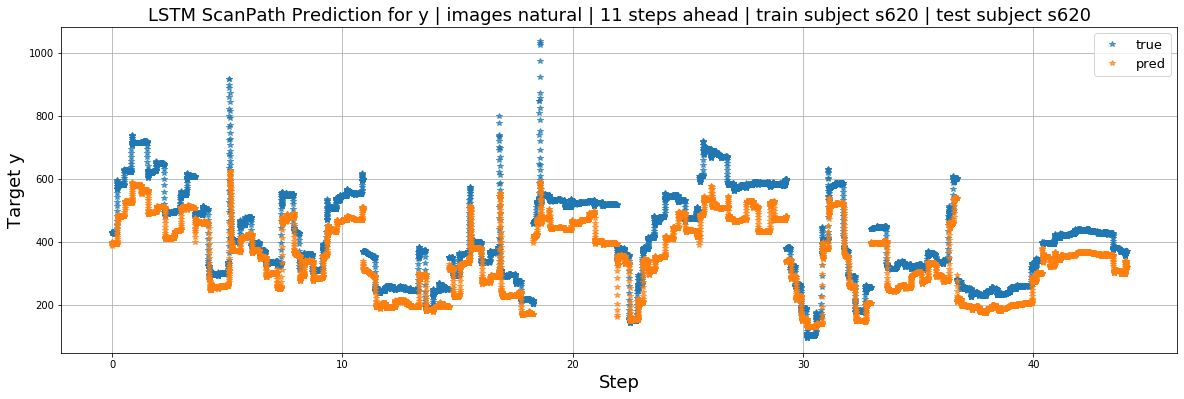

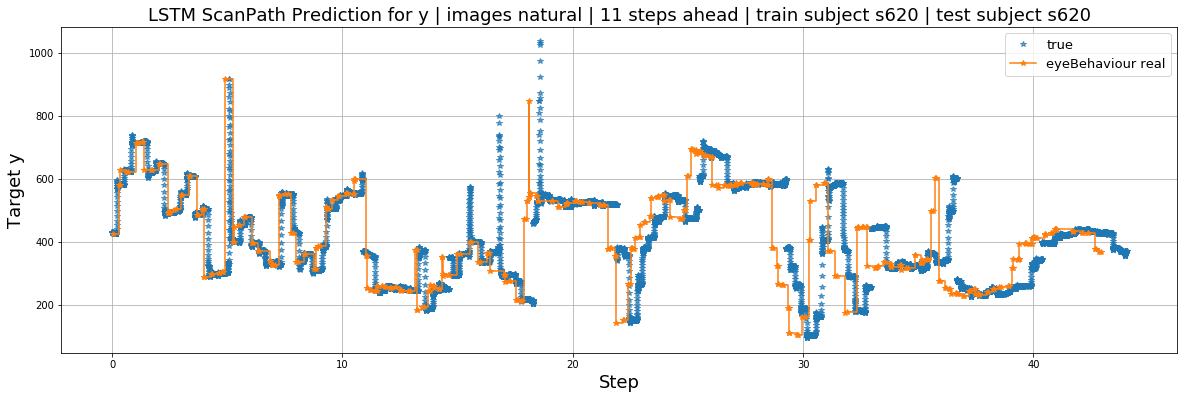

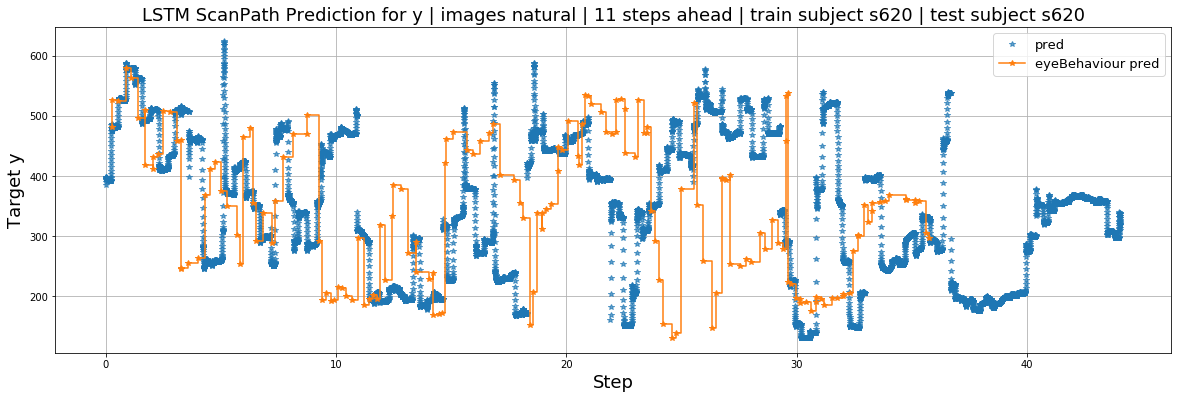

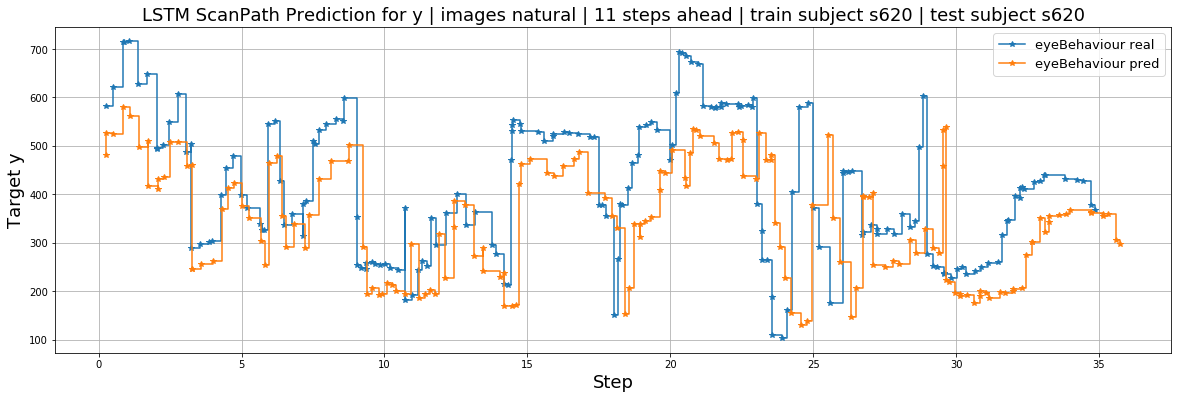

In [36]:
# Plot
x_lim = None
for x_or_y in ["x", "y"]:
    # plot real vs pred
    plt.figure(figsize=(20,6))
    plt.plot(y_real_plot[x_or_y], 'C0*', label='true', alpha=0.7)
    plt.plot(y_pred_plot[x_or_y], 'C1*', label='pred', alpha=0.7)
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()
    # plot real vs eyebehaviour real
    plt.figure(figsize=(20,6))
    plt.plot(y_real_plot[x_or_y], 'C0*', label='true', alpha=0.7)
    xy = f"start_{x_or_y}"
    plt.step(df_path_real["duration"].cumsum(), df_path_real[xy], "C1-*", where="post", label="eyeBehaviour real")
    #plt.step(fix_real["duration"].cumsum(), fix_real[xy], "C1-*", where="post", label="eyeBehaviour real")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()
    # plot pred vs eyebehaviour pred
    plt.figure(figsize=(20,6))
    plt.plot(y_pred_plot[x_or_y], 'C0*', label='pred', alpha=0.7)
    xy = f"start_{x_or_y}"
    plt.step(fix_pred["duration"].cumsum(), fix_pred[xy], "C1-*", where="post", label="eyeBehaviour pred")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()
    # eyebehaviour real vs eyebehaviour pred
    plt.figure(figsize=(20,6))
    xy = f"start_{x_or_y}"
    plt.step(fix_real["duration"].cumsum(), fix_real[xy], "C0-*", where="post", label="eyeBehaviour real")
    plt.step(fix_pred["duration"].cumsum(), fix_pred[xy], "C1-*", where="post", label="eyeBehaviour pred")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()

## Test Remodnav

In [37]:
from utils.MetricsCalculator import eyeBehaviour_remodnav, format_output_remodnav
# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)
mcdropout_mean.reset_index(inplace=True, drop=True)
mcdropout_std.reset_index(inplace=True, drop=True)

events_real = eyeBehaviour_remodnav(y_real)
events_pred = eyeBehaviour_remodnav(y_pred)
sac_real_remodnav, fix_real_remodnav = format_output_remodnav(events_real)
sac_pred_remodnav, fix_pred_remodnav = format_output_remodnav(events_pred)
#m.docomparison(fix_real_remodnav, fix_pred_remodnav, screensize=[1920, 1080])

# Plot
y_real_plot = y_real.copy()
y_pred_plot = y_pred.copy()
y_real_plot.index = (idx*0.002).squeeze()
y_pred_plot.index = (idx*0.002).squeeze()

===========> Working on natural images


/home/camilojd/anaconda3/envs/scanpath-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/camilojd/anaconda3/envs/scanpath-env/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/camilojd/Universidad/ScanPaths/LSTM/src/utils/MetricsCalculator.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sac["duration"] = df_sac["end_time"] - df_sac["start_time"]
/home/camilojd/Universidad/ScanPaths/LSTM/src/utils/MetricsCalculator.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

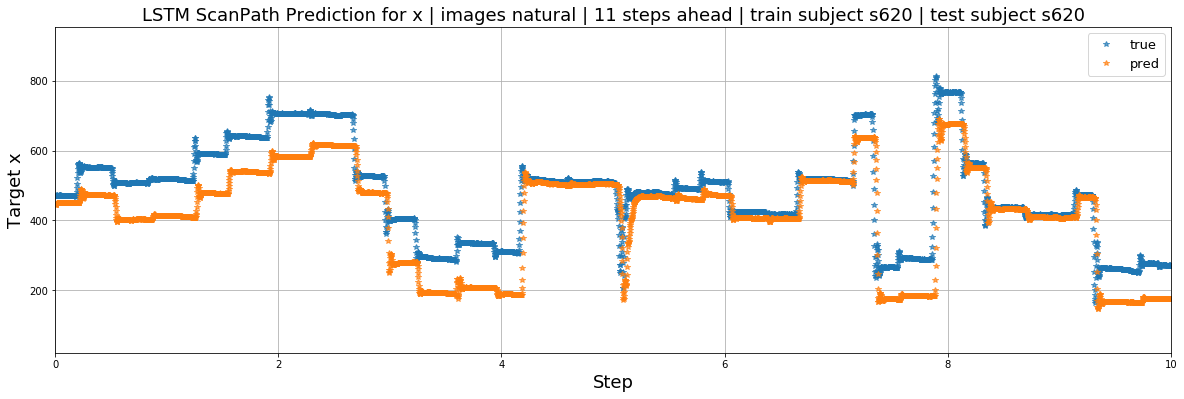

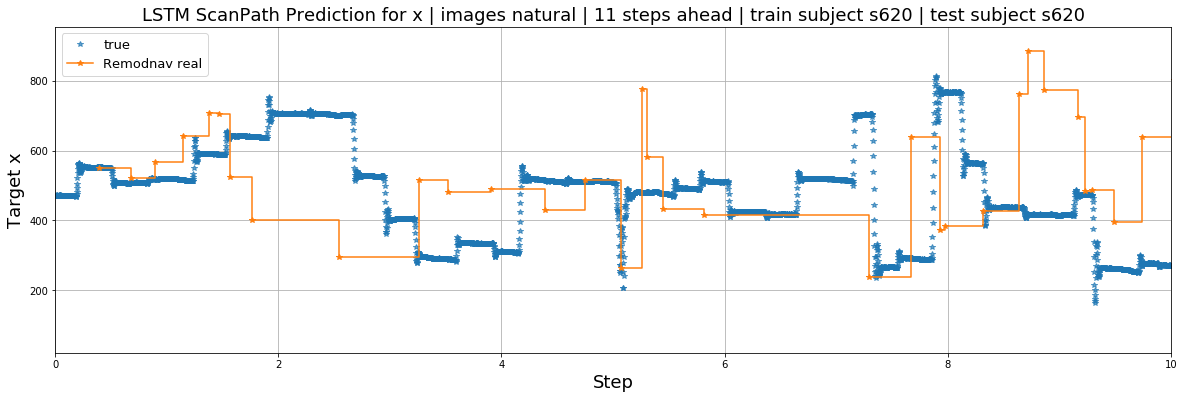

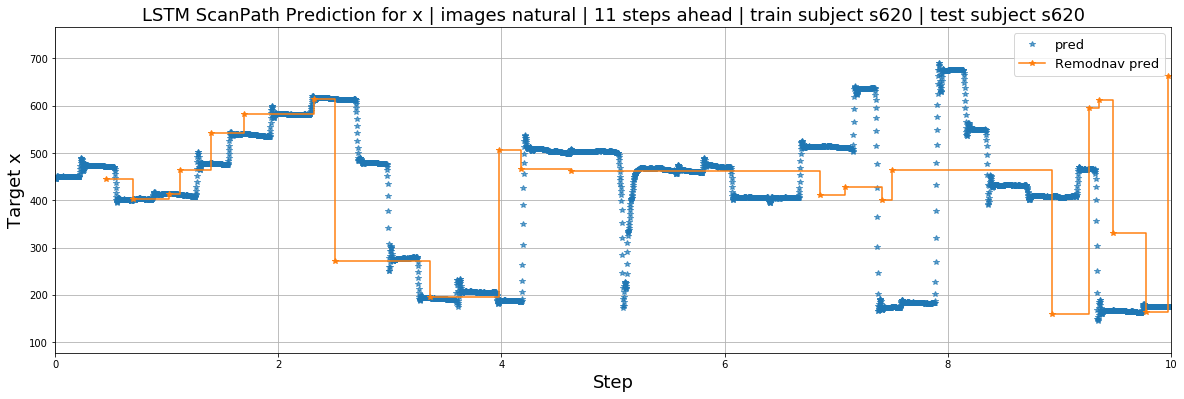

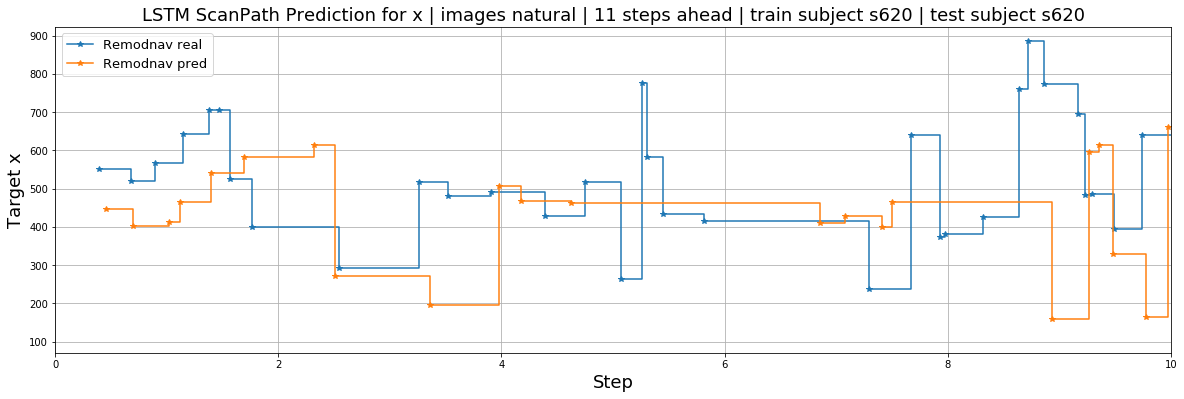

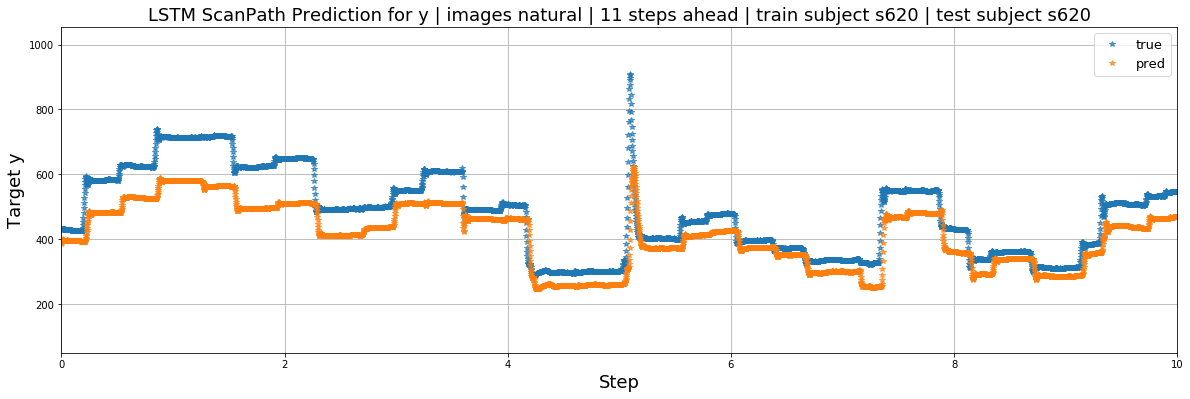

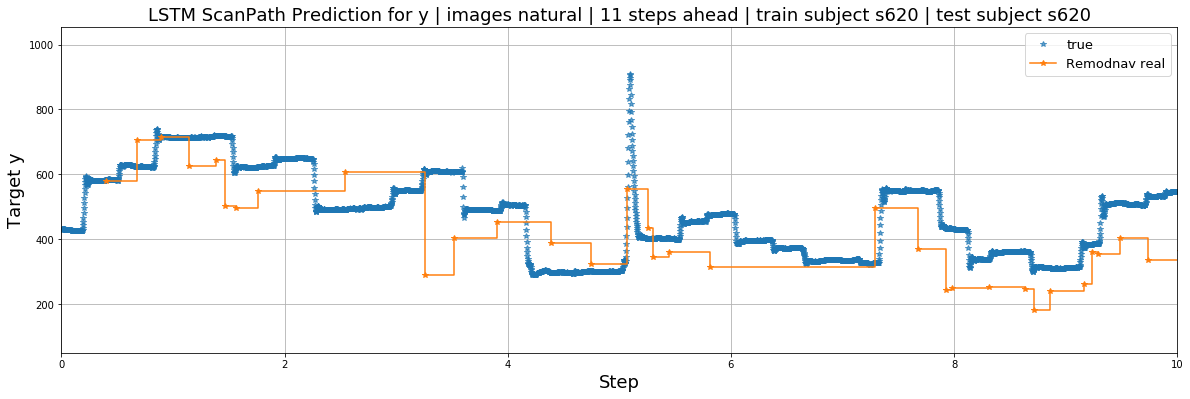

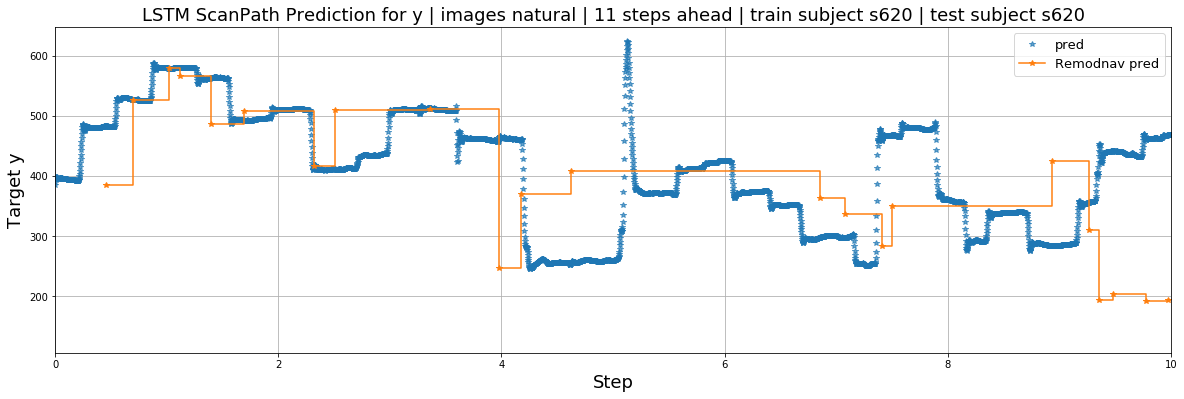

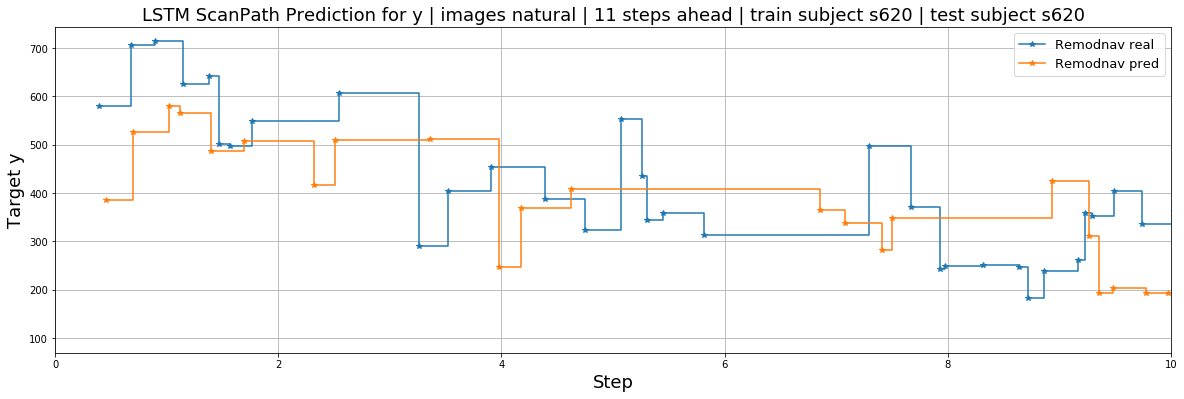

In [38]:
# Plot
x_lim = (0,10)
for x_or_y in ["x", "y"]:
    # plot real vs pred
    plt.figure(figsize=(20,6))
    plt.plot(y_real_plot[x_or_y], 'C0*', label='true', alpha=0.7)
    plt.plot(y_pred_plot[x_or_y], 'C1*', label='pred', alpha=0.7)
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()
    # plot real vs eyebehaviour real
    plt.figure(figsize=(20,6))
    plt.plot(y_real_plot[x_or_y], 'C0*', label='true', alpha=0.7)
    xy = f"start_{x_or_y}"
    plt.step(fix_real_remodnav["duration"].cumsum(), fix_real_remodnav[xy], "C1-*", where="post", label="Remodnav real")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()
    # plot pred vs eyebehaviour pred
    plt.figure(figsize=(20,6))
    plt.plot(y_pred_plot[x_or_y], 'C0*', label='pred', alpha=0.7)
    xy = f"start_{x_or_y}"
    plt.step(fix_pred_remodnav["duration"].cumsum(), fix_pred_remodnav[xy], "C1-*", where="post", label="Remodnav pred")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()
    # eyebehaviour real vs eyebehaviour pred
    plt.figure(figsize=(20,6))
    xy = f"start_{x_or_y}"
    plt.step(fix_real_remodnav["duration"].cumsum(), fix_real_remodnav[xy], "C0-*", where="post", label="Remodnav real")
    plt.step(fix_pred_remodnav["duration"].cumsum(), fix_pred_remodnav[xy], "C1-*", where="post", label="Remodnav pred")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()

## Comparison eyeBehaviour vs Remodnav

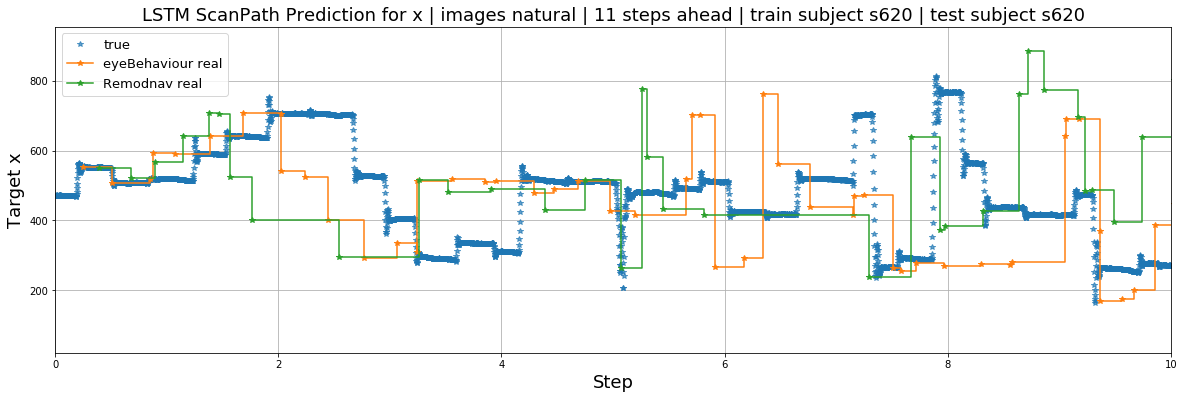

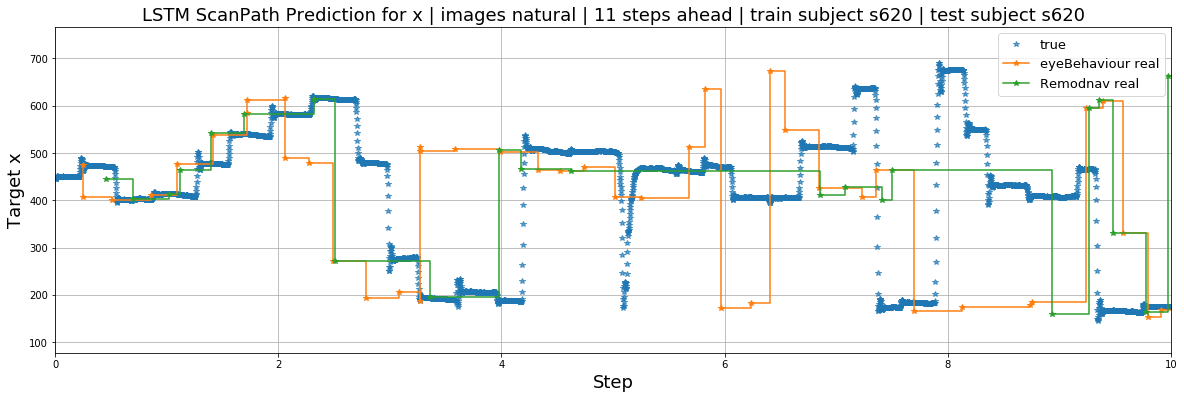

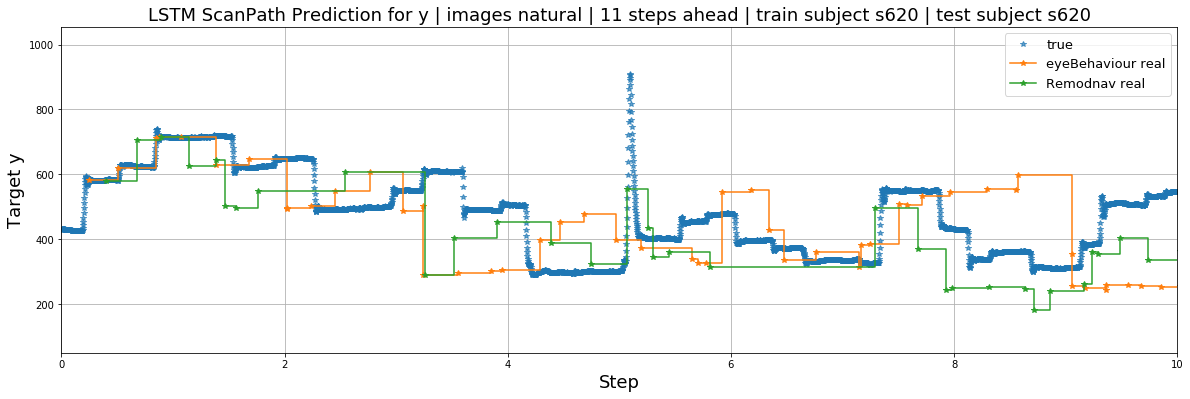

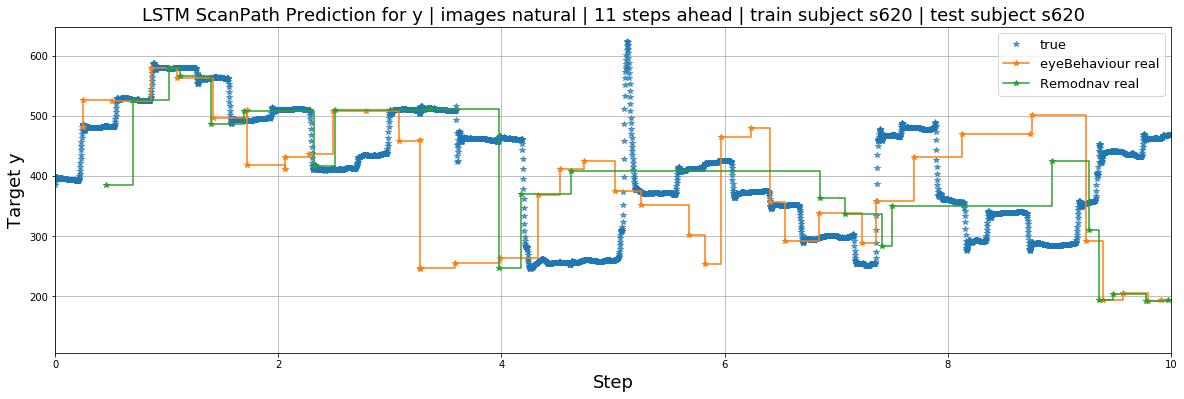

In [39]:
# Plot
x_lim = (0,10)
for x_or_y in ["x", "y"]:
    # eyebehaviour real vs remodnav real
    plt.figure(figsize=(20,6))
    xy = f"start_{x_or_y}"
    plt.plot(y_real_plot[x_or_y], 'C0*', label='true', alpha=0.7)
    plt.step(fix_real["duration"].cumsum(), fix_real[xy], "C1-*", where="post", label="eyeBehaviour real")
    plt.step(fix_real_remodnav["duration"].cumsum(), fix_real_remodnav[xy], "C2-*", where="post", label="Remodnav real")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()
    
    # eyebehaviour pred vs remodnav pred
    plt.figure(figsize=(20,6))
    xy = f"start_{x_or_y}"
    plt.plot(y_pred_plot[x_or_y], 'C0*', label='true', alpha=0.7)
    plt.step(fix_pred["duration"].cumsum(), fix_pred[xy], "C1-*", where="post", label="eyeBehaviour real")
    plt.step(fix_pred_remodnav["duration"].cumsum(), fix_pred_remodnav[xy], "C2-*", where="post", label="Remodnav real")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()

## Test multimatch

In [40]:
import multimatch_gaze as m
from utils.MetricsCalculator import calculate_multimatch
# Params
N = 11
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15

tIMG = "natural"
predIMG = "natural"

# Subject
subject_train = "s620" #s605, s617, s620

# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(params.RESULTS_FOLDER,
                          train_path)

# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)
mcdropout_mean.reset_index(inplace=True, drop=True)
mcdropout_std.reset_index(inplace=True, drop=True)

# Test eye Behaviour
idx = np.expand_dims(np.arange(len(y_pred)), -1)
y_real_eye = np.concatenate([idx, y_real], axis=1)
events_real = eyeBehaviour(y_real_eye)
sac_real, fix_real = format_output_eyeBehaviour(events_real)

# Plot
y_real_plot = y_real.copy()
y_pred_plot = y_pred.copy()
y_real_plot.index = (idx*0.002).squeeze()
y_pred_plot.index = (idx*0.002).squeeze()


===========> Working on natural images


### real == pred

[1.0, 1.0, 1.0, 1.0, 1.0]


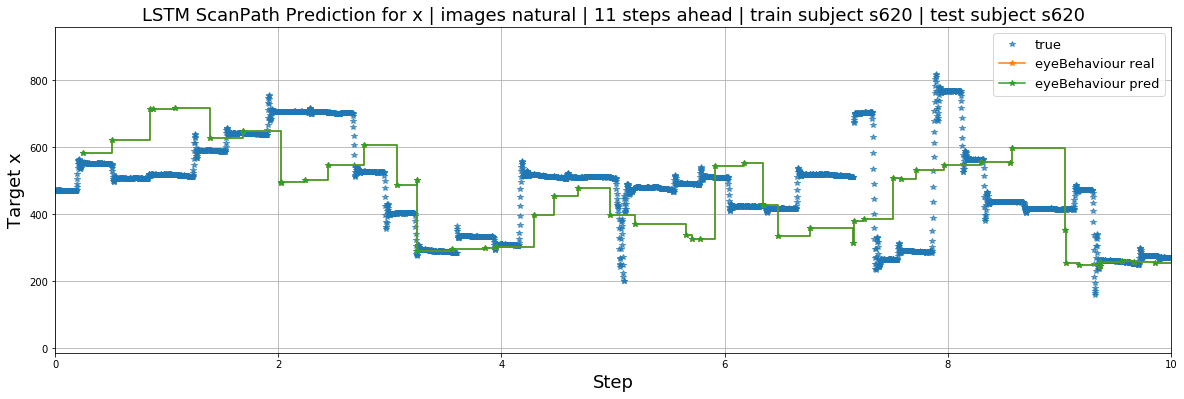

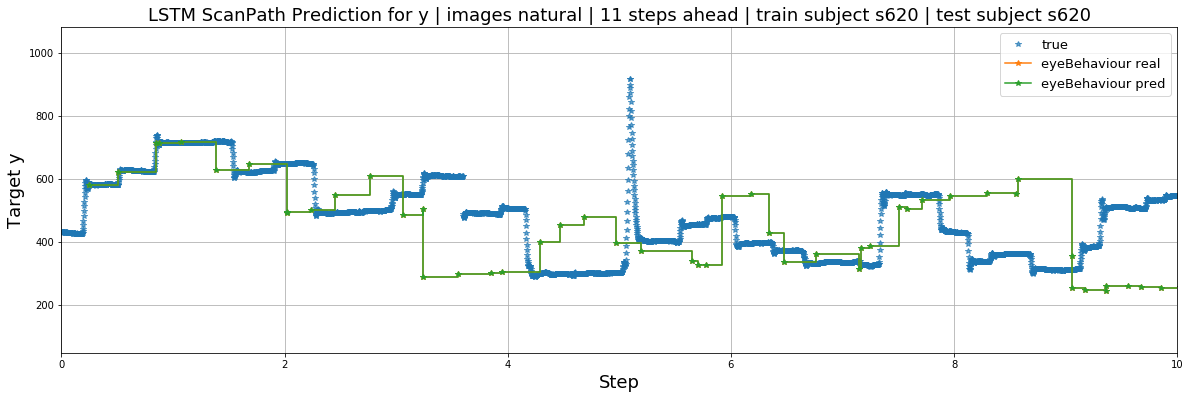

In [41]:
x_lim = (0, 10)
fix_pred = fix_real.copy()
print(m.docomparison(fix_real, fix_pred, screensize=[1920, 1080]))
for x_or_y in ["x", "y"]:
    plt.figure(figsize=(20,6))
    plt.plot(y_real_plot[x_or_y], 'C0*', label='true', alpha=0.7)
    plt.step(fix_real["duration"].cumsum(), fix_real[xy], "C1-*", where="post", label="eyeBehaviour real")
    plt.step(fix_pred["duration"].cumsum(), fix_pred[xy], "C2-*", where="post", label="eyeBehaviour pred")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)

### pred[duration] += number

[1.0, 1.0, 1.0, 1.0, 0.9]


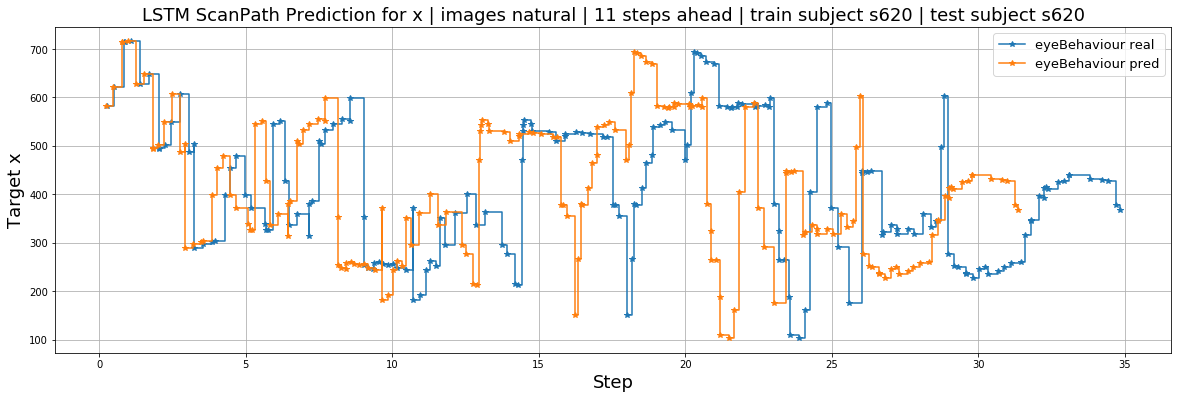

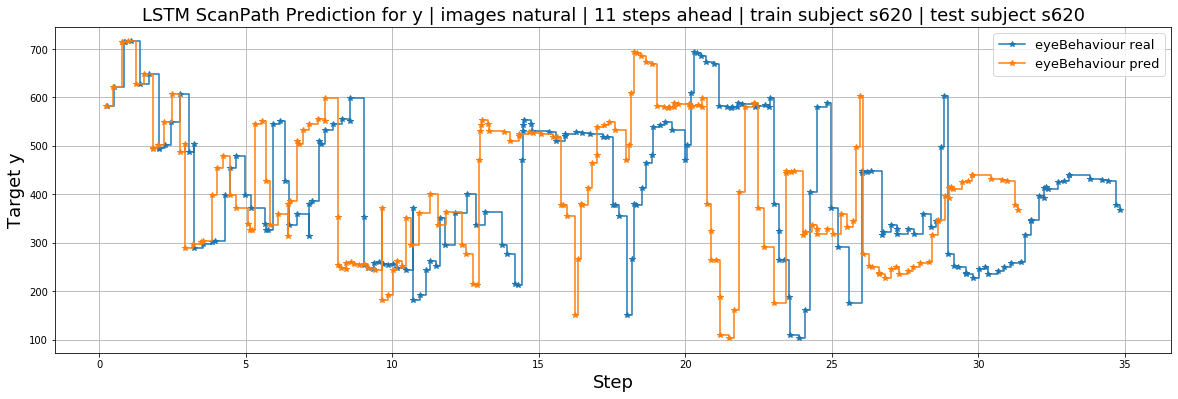

In [42]:
fix_pred = fix_real.copy()
#fix_pred["duration"] += 0.01
fix_pred["duration"] *= 0.9
print(m.docomparison(fix_real, fix_pred, screensize=[1920, 1080]))
for x_or_y in ["x", "y"]:
    plt.figure(figsize=(20,6))
    plt.step(fix_real["duration"].cumsum(), fix_real[xy], "C0-*", where="post", label="eyeBehaviour real")
    plt.step(fix_pred["duration"].cumsum(), fix_pred[xy], "C1-*", where="post", label="eyeBehaviour pred")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N)

### Subject s622, mduration = 0.5

In [43]:
# Params
N = 5
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15

tIMG = "natural"
predIMG = "natural"

# Subjects
subject_train = "s622"

# Test against themselves
# -----------------------
# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(params.RESULTS_FOLDER,
                          train_path)
# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)
mcdropout_mean.reset_index(inplace=True, drop=True)
mcdropout_std.reset_index(inplace=True, drop=True)

# Test eye Behaviour
idx = np.expand_dims(np.arange(len(y_pred)), -1)
y_real_eye = np.concatenate([idx, y_real], axis=1)
y_pred_eye = np.concatenate([idx, y_pred], axis=1)
events_real = eyeBehaviour(y_real_eye)
events_pred = eyeBehaviour(y_pred_eye)
_, fix_real_s622 = format_output_eyeBehaviour(events_real)

# Plot
y_real_s622 = y_real.copy()
y_pred_s622 = y_pred.copy()
y_real_s622.index = (idx*0.002).squeeze()
y_pred_s622.index = (idx*0.002).squeeze()

===========> Working on natural images


[0.997008122390901, 0.9376260257256002, 0.9964780211481014, 0.9784400830275781, 0.5714285714285714]


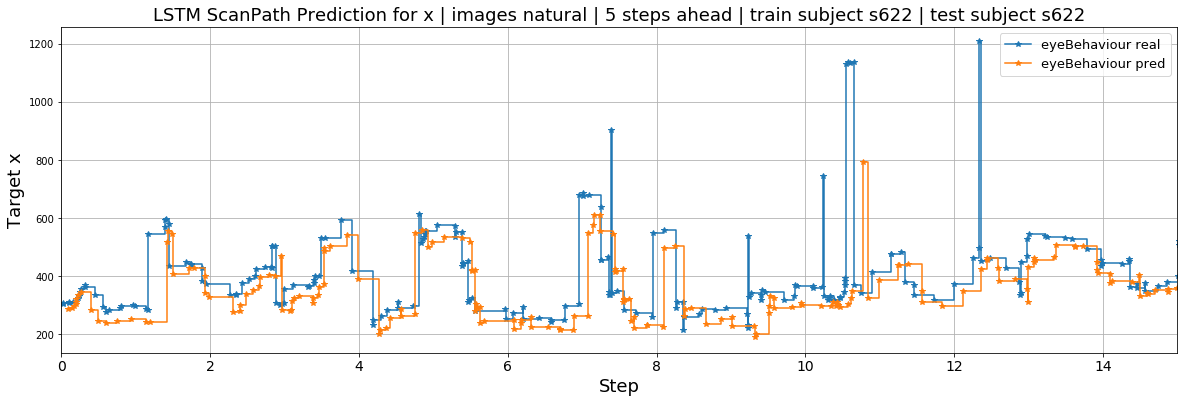

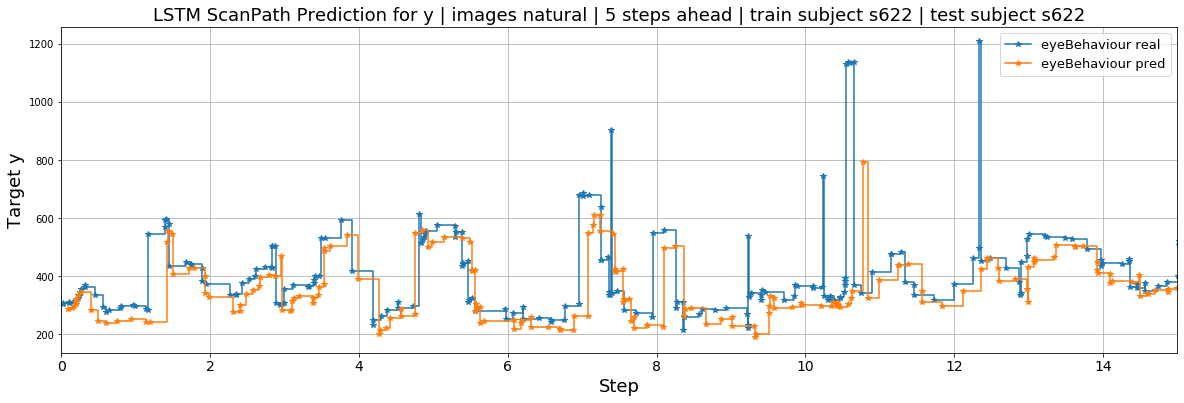

In [44]:
x_lim = (0, 15)
_, fix_pred_s622 = format_output_eyeBehaviour(events_pred)
print(m.docomparison(fix_real_s622, fix_pred_s622, screensize=[1920, 1080]))
#print(m.docomparison(fix_real_s622[x_lim[0]:x_lim[1]].reset_index(drop=True), fix_pred_s622[x_lim[0]:x_lim[1]].reset_index(drop=True), screensize=[1920, 1080]))
for x_or_y in ["x", "y"]:
    plt.figure(figsize=(20,6))
    plt.step(fix_real_s622["duration"].cumsum(), fix_real_s622[xy], "C0-*", where="post", label="eyeBehaviour real")
    plt.step(fix_pred_s622["duration"].cumsum(), fix_pred_s622[xy], "C1-*", where="post", label="eyeBehaviour pred")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.xticks(fontsize=14)

### Subject s620 mduration = 0.95

In [45]:
# Params
N = 5
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15

tIMG = "natural"
predIMG = "natural"

# Subjects
subject_train = "s620"

# Test against themselves
# -----------------------
# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(params.RESULTS_FOLDER,
                          train_path)
# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)
mcdropout_mean.reset_index(inplace=True, drop=True)
mcdropout_std.reset_index(inplace=True, drop=True)

# Test eye Behaviour
idx = np.expand_dims(np.arange(len(y_pred)), -1)
y_real_eye = np.concatenate([idx, y_real], axis=1)
y_pred_eye = np.concatenate([idx, y_pred], axis=1)
events_real = eyeBehaviour(y_real_eye)
events_pred = eyeBehaviour(y_pred_eye)
_, fix_real_s620 = format_output_eyeBehaviour(events_real)

# Plot
y_real_s620 = y_real.copy()
y_pred_s620 = y_pred.copy()
y_real_s620.index = (idx*0.002).squeeze()
y_pred_s620.index = (idx*0.002).squeeze()

===========> Working on natural images


[0.9959095201688238, 0.9553112735056175, 0.9944930740148961, 0.973240710774093, 0.9508196721311476]


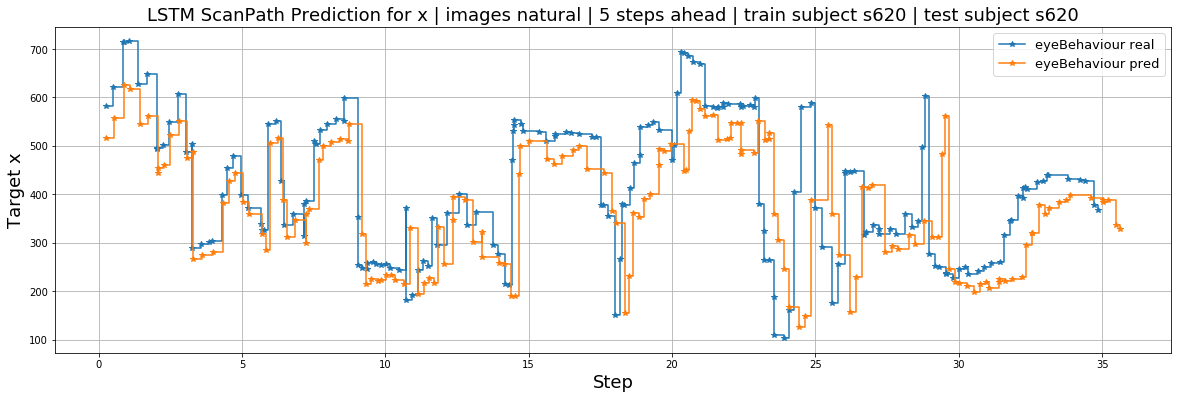

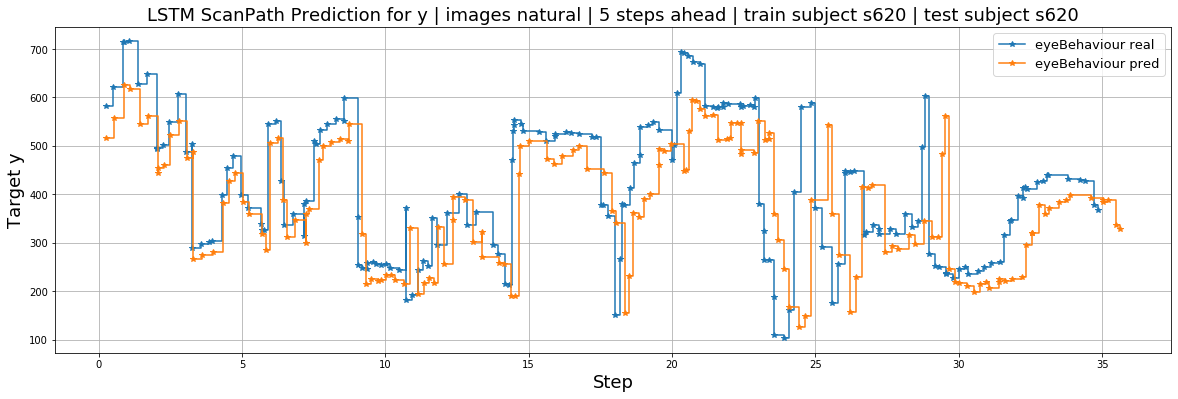

In [46]:
_, fix_pred_s620 = format_output_eyeBehaviour(events_pred)
print(m.docomparison(fix_real_s620, fix_pred_s620, screensize=[1920, 1080]))
for x_or_y in ["x", "y"]:
    plt.figure(figsize=(20,6))
    plt.step(fix_real_s620["duration"].cumsum(), fix_real_s620[xy], "C0-*", where="post", label="eyeBehaviour real")
    plt.step(fix_pred_s620["duration"].cumsum(), fix_pred_s620[xy], "C1-*", where="post", label="eyeBehaviour pred")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N)

### s620 vs s622

s620: [0.9959095201688238, 0.9553112735056175, 0.9944930740148961, 0.973240710774093, 0.9508196721311476]
s622: [0.997008122390901, 0.9376260257256002, 0.9964780211481014, 0.9784400830275781, 0.5714285714285714]


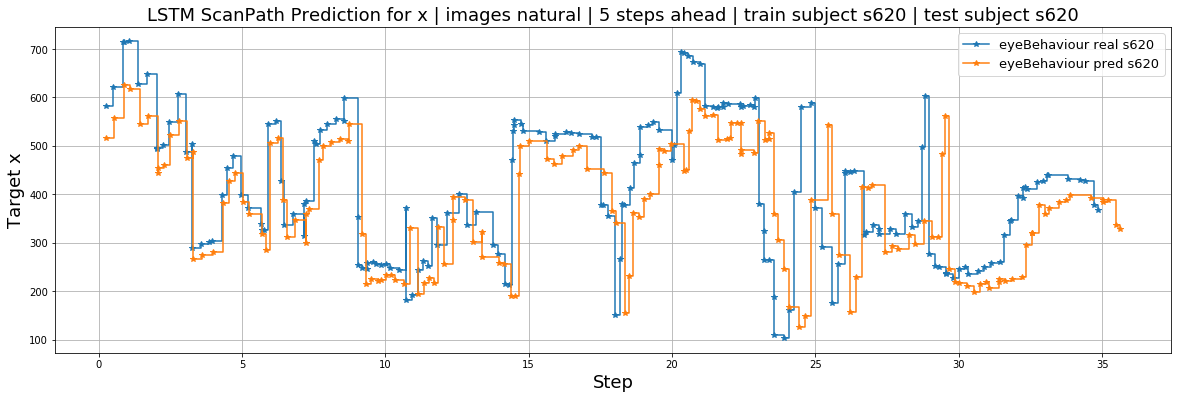

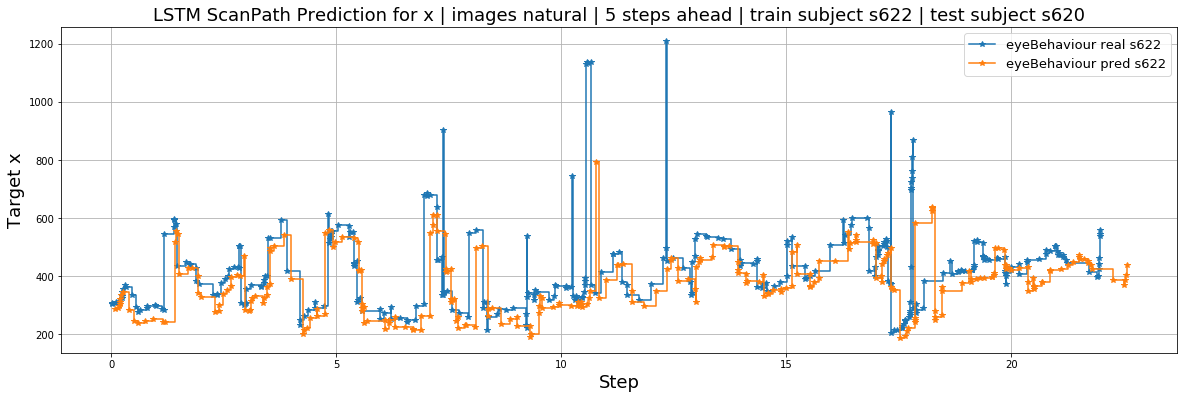

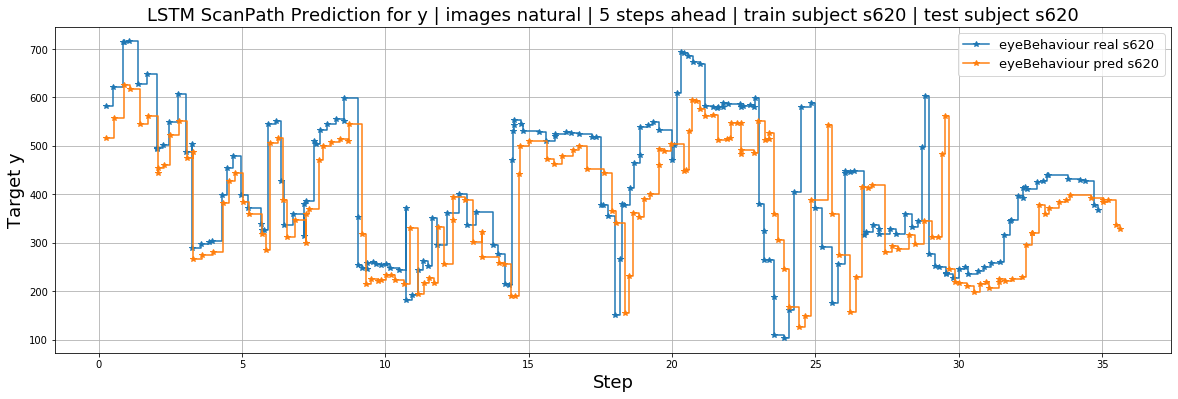

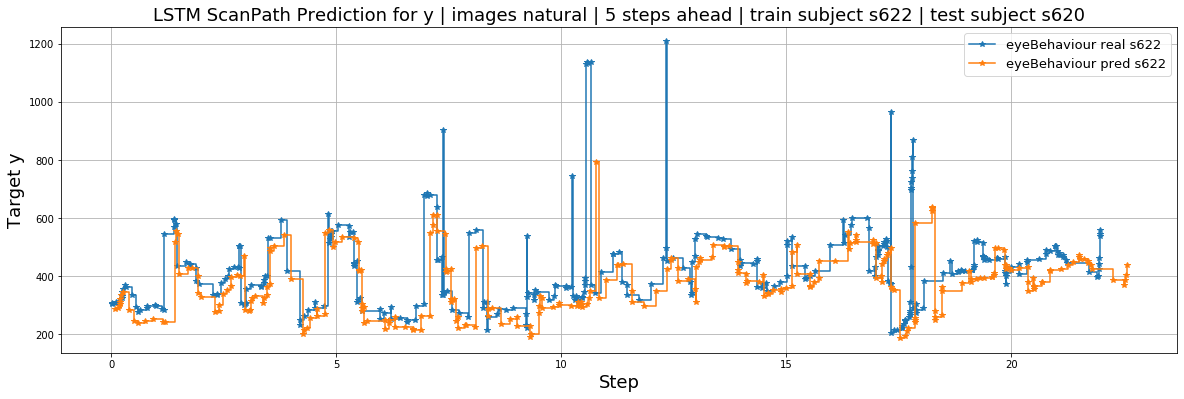

In [47]:
print("s620:", m.docomparison(fix_real_s620, fix_pred_s620, screensize=[1920, 1080]))
print("s622:", m.docomparison(fix_real_s622, fix_pred_s622, screensize=[1920, 1080]))

for x_or_y in ["x", "y"]:
    plt.figure(figsize=(20,6))
    #plt.plot(y_real_s620[x_or_y], 'C0*', label='true s620', alpha=0.7)
    plt.step(fix_real_s620["duration"].cumsum(), fix_real_s620[xy], "C0-*", where="post", label="eyeBehaviour real s620")
    plt.step(fix_pred_s620["duration"].cumsum(), fix_pred_s620[xy], "C1-*", where="post", label="eyeBehaviour pred s620")
    plot_config_prediction(x_or_y, "s620", subject_train, N=N)
    
    plt.figure(figsize=(20,6))
    #plt.plot(y_real_s622[x_or_y], 'C0*', label='true', alpha=0.7)
    plt.step(fix_real_s622["duration"].cumsum(), fix_real_s622[xy], "C0-*", where="post", label="eyeBehaviour real s622")
    plt.step(fix_pred_s622["duration"].cumsum(), fix_pred_s622[xy], "C1-*", where="post", label="eyeBehaviour pred s622")
    plot_config_prediction(x_or_y, "s622", subject_train, N=N)

# [X] Check Scanmatch 

In [50]:
# Params
N = 5
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15

tIMG = "natural"
predIMG = "natural"

# Subjects
subject_train = "s620"

# Test against themselves
# -----------------------
# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(params.RESULTS_FOLDER,
                          train_path)
# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)
mcdropout_mean.reset_index(inplace=True, drop=True)
mcdropout_std.reset_index(inplace=True, drop=True)

===========> Working on natural images


In [51]:
def scanpath_to_string(scanpath, height, width, Xbins, Ybins, Tbins):
    """
            a b c d ...
        A
        B
        C
        D

        returns Aa
    """
    if Tbins !=0:
        try:
            assert scanpath.shape[1] == 3
        except Exception as x:
            print("Temporal information doesn't exist.")

    height_step, width_step = height//Ybins, width//Xbins
    string = ''
    num = list()
    for i in range(scanpath.shape[0]):
        fixation = scanpath[i].astype(np.int32)
        xbin = fixation[0]//width_step
        ybin = ((height - fixation[1])//height_step)
        corrs_x = chr(65 + xbin)
        corrs_y = chr(97 + ybin)
        T = 1
        if Tbins:
            T = fixation[2]//Tbins
        for t in range(T):
            string += (corrs_y + corrs_x)
            num += [(ybin * Xbins) + xbin]
    return string, num

In [52]:
def global_align(P, Q, SubMatrix=None, gap=0, match=1, mismatch=-1):
    """
        https://bitbucket.org/brentp/biostuff/src/
    """
    UP, LEFT, DIAG, NONE = range(4)
    max_p = len(P)
    max_q = len(Q)
    score   = np.zeros((max_p + 1, max_q + 1), dtype='f')
    pointer = np.zeros((max_p + 1, max_q + 1), dtype='i')

    pointer[0, 0] = NONE
    score[0, 0] = 0.0
    pointer[0, 1:] = LEFT
    pointer[1:, 0] = UP

    score[0, 1:] = gap * np.arange(max_q)
    score[1:, 0] = gap * np.arange(max_p).T

    for i in range(1, max_p + 1):
        ci = P[i - 1]
        for j in range(1, max_q + 1):
            cj = Q[j - 1]
            if SubMatrix is None:
                diag_score = score[i - 1, j - 1] + (cj == ci and match or mismatch)
            else:
                diag_score = score[i - 1, j - 1] + SubMatrix[cj][ci]
            up_score   = score[i - 1, j] + gap
            left_score = score[i, j - 1] + gap

            if diag_score >= up_score:
                if diag_score >= left_score:
                    score[i, j] = diag_score
                    pointer[i, j] = DIAG
                else:
                    score[i, j] = left_score
                    pointer[i, j] = LEFT
            else:
                if up_score > left_score:
                    score[i, j ]  = up_score
                    pointer[i, j] = UP
                else:
                    score[i, j]   = left_score
                    pointer[i, j] = LEFT

    align_j = ""
    align_i = ""
    while True:
        p = pointer[i, j]
        if p == NONE: break
        s = score[i, j]
        if p == DIAG:
            # align_j += Q[j - 1]
            # align_i += P[i - 1]
            i -= 1
            j -= 1
        elif p == LEFT:
            # align_j += Q[j - 1]
            # align_i += "-"
            j -= 1
        elif p == UP:
            # align_j += "-"
            # align_i += P[i - 1]
            i -= 1
        else:
            raise ValueError
    # return align_j[::-1], align_i[::-1]
    return score.max()

In [61]:
def scan_match(P, Q, height, width, Xbins=12, Ybins=8, Tbins=0,
                SubMatrix=None, threshold=3.5, GapValue=0 ,**kwargs):
    """
        ScanMatch
        You need to creat ScanMatchInfo file before hand in the matlab yourself.

        for more information have look at:
            https://seis.bristol.ac.uk/~psidg/ScanMatch/

    """

    def _create_sub_matrix(Xbins, Ybins, threshold):

        mat = np.zeros((Xbins * Ybins, Xbins * Ybins))
        idx_i = 0
        idx_j = 0

        for i in range(Ybins):
            for j in range(Xbins):
                for ii in range(Ybins):
                    for jj in range(Xbins):
                        mat[idx_i, idx_j] = np.sqrt((j-jj)**2 + (i-ii)**2)
                        idx_i +=1
                idx_i =0
                idx_j += 1

        max_sub = mat.max()
        return np.abs(mat - max_sub) - (max_sub - threshold)

    try:

        P = np.array(P, dtype=np.float32)
        Q = np.array(Q, dtype=np.float32)
        P, P_num = scanpath_to_string(P, height, width, Xbins, Ybins, Tbins)
        Q, Q_num = scanpath_to_string(Q, height, width, Xbins, Ybins, Tbins)
        
        if SubMatrix is None:
            SubMatrix = _create_sub_matrix(Xbins, Ybins, threshold)
        score = global_align(P_num, Q_num, SubMatrix, GapValue)
        scale = SubMatrix.max() * max(len(P_num), len(Q_num))

        return score / scale

    except Exception as e:
        print(e)
        return np.nan

In [62]:
scan_match(y_real, y_pred, params.data_params.HEIGHT_ORIG, params.data_params.WIDTH_ORIG)

scanpath_to_string
SubMatrix
global_align
scale


0.8842643778488992

In [63]:
# Params
N = 5
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15

tIMG = "natural"
predIMG = "natural"

# Subjects
subject_train = "s622"

# Test against themselves
# -----------------------
# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(params.RESULTS_FOLDER,
                          train_path)
# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)
mcdropout_mean.reset_index(inplace=True, drop=True)
mcdropout_std.reset_index(inplace=True, drop=True)

# Test eye Behaviour
idx = np.expand_dims(np.arange(len(y_pred)), -1)
y_real_eye = np.concatenate([idx, y_real], axis=1)
y_pred_eye = np.concatenate([idx, y_pred], axis=1)
events_real = eyeBehaviour(y_real_eye)
events_pred = eyeBehaviour(y_pred_eye)
_, fix_real_s622 = format_output_eyeBehaviour(events_real)

# Plot
y_real_s622 = y_real.copy()
y_pred_s622 = y_pred.copy()
y_real_s622.index = (idx*0.002).squeeze()
y_pred_s622.index = (idx*0.002).squeeze()

===========> Working on natural images


In [64]:
scan_match(y_real, y_pred, params.data_params.HEIGHT_ORIG, params.data_params.WIDTH_ORIG)

scanpath_to_string
SubMatrix
global_align
scale


0.8511508109988937

# [$\checkmark$] DTW

In [79]:
def DTW(P, Q, **kwargs):
    from fastdtw import fastdtw
    from scipy.spatial.distance import euclidean
    dist, _ =  fastdtw(P, Q, dist=euclidean)
    return dist

1105002.7819150537

In [ ]:
DTW(y_real, y_pred)

In [81]:
def DET(P,Q, threshold, **kwargs):
    """
        https://link.springer.com/content/pdf/10.3758%2Fs13428-014-0550-3.pdf
    """
    def _C(P, Q, threshold):
        assert (P.shape == Q.shape)
        shape = P.shape[0]
        c = np.zeros((shape, shape))

        for i in range(shape):
            for j in range(shape):
                if euclidean(P[i], Q[j]) < threshold:
                    c[i,j] = 1
        return c


    P = np.array(P, dtype=np.float32)
    Q = np.array(Q, dtype=np.float32)
    min_len = P.shape[0] if (P.shape[0] < Q.shape[0]) else Q.shape[0]
    P = P[:min_len,:2]
    Q = Q[:min_len,:2]

    c = _C(P, Q, threshold)
    R = np.triu(c,1).sum()

    counter = 0
    for i in range(1,min_len):
        data = c.diagonal(i)
        data = ''.join([str(item) for item in data])
        counter += len(re.findall('1{2,}', data))


    return 100 * (counter / R)

In [ ]:
DET(y_real, y_pred, threshold=50)

# [X] Check for selected step ahead and MCDropout

In [48]:
from copy import copy

def create_ellipses_error(mcdropout_mean, mcdropout_std, color="C2"):
    ellipses = []
    for mean, std in zip(mcdropout_mean.values, mcdropout_std.values):
        ellipse = matplotlib.patches.Ellipse(
            (mean[0], mean[1]), 
            std[0], std[1], alpha=0.1, color=color)
        ellipses.append(ellipse)
    return ellipses

In [49]:
# Define x_lim for plot
x_lim = (740, 820)

# Select N_STEP of interest
N_STEP = 11

# Define y_real and pred
y_pred = y_pred_dict[N_STEP][x_lim[0]:x_lim[1]]
y_real = y_real_dict[N_STEP][x_lim[0]:x_lim[1]]

# Define mcdropout mean, std and lstm_pred
mcdropout_mean = mcdropout_mean_dict[N_STEP][x_lim[0]:x_lim[1]]
mcdropout_std = mcdropout_std_dict[N_STEP][x_lim[0]:x_lim[1]]

# Create ellipses for drawing dropout error
ellipses = create_ellipses_error(mcdropout_mean, mcdropout_std)

# Plot selected image on scanpath
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(0, params.data_params.WIDTH)
ax.set_ylim(0, params.data_params.HEIGHT)
line1, = ax.plot(0, 0)
line2, = ax.plot(0, 0)
line1.set_label("true")
line2.set_label("pred")
line1.set_color("C0")  
line2.set_color("C1")
plt.legend()
plt.title(f"Scanpath of subject {SUBJECT} - {N_STEP} steps ahead", fontsize=18)
img = np.flipud(plt.imread(f"{params.data_params.IMGS_FOLDER}/{img_test}"))
ax.imshow(img)
line1.set_xdata(y_real["x"])
line1.set_ydata(y_real["y"])
line2.set_xdata(y_pred["x"])
line2.set_ydata(y_pred["y"])
plt.xlabel("x-pos", fontsize=18)
plt.ylabel(f"y-pos", fontsize=18)

for ellipse in ellipses:
    new_e = copy(ellipse)
    ax.add_patch(new_e)


# Plot time-series
#percentile = 70
for x_or_y in ["x", "y"]:
    plt.figure(figsize=(13,5))
    plt.plot(y_real[x_or_y], 'C0*', label='true', alpha=0.7)
    plt.plot(y_pred[x_or_y], 'C1*', label='predicted', alpha=0.7)
    # Plot mean std
    plt.plot(mcdropout_mean[x_or_y], 'C2-', label='predicted mean', alpha=0.7)
    plt.fill_between(y_real[x_or_y].index, mcdropout_mean[x_or_y] - mcdropout_std[x_or_y],
                     mcdropout_mean[x_or_y] + mcdropout_std[x_or_y], color='C2', alpha='0.4')
    # Plot percentile
    #plt.plot(np.percentile(lstm_mcdropout_pred, q=percentile, axis=0)[:, 0 if x_or_y == "x" else 1],'C3', label=f'Percentile {percentile}', alpha=0.7)

    plt.legend(loc='best', prop={'size': 13})
    plt.title(f'LSTM MC-Dropout ScanPath Prediction for {x_or_y}-pos | img {params.labels_params.TRAIN_IMG_TYPE} {img_test} | subject {SUBJECT} | {N_STEP} steps ahead', fontsize=18)
    plt.grid()
    plt.ylabel(f"{x_or_y}-pos", fontsize=18)
    plt.xlabel("Step", fontsize=18)
    plt.show()

NameError: name 'mcdropout_mean_dict' is not defined

# [X] Check for every step ahead

In [ ]:
# Define x_lim for plot
x_lim = (740, 820)

"""
Configuration
"""
# Config plot image
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(0, params.data_params.WIDTH)
ax.set_ylim(0, params.data_params.HEIGHT)
img = np.flipud(plt.imread(f"{params.data_params.IMGS_FOLDER}/{img_test}"))
ax.imshow(img)
ax.set_title(f"Scanpath of subject {SUBJECT} | img {params.labels_params.TRAIN_IMG_TYPE} {img_test}", fontsize=18)
ax.set_xlabel("x-pos", fontsize=18)
ax.set_ylabel("y-pos", fontsize=18)

title = 'LSTM MC-Dropout ScanPath Prediction for {}-pos | img {} {} | subject {}'
# Config plot timeseries x-pos
fig1, ax1 = plt.subplots(figsize=(13,5))
ax1.grid()
ax1.set_ylabel("x-pos", fontsize=18)
ax1.set_xlabel("Step", fontsize=18)

# Config plot timeseries y-pos
fig2, ax2 = plt.subplots(figsize=(13,5))
ax2.grid()
ax2.set_ylabel("y-pos", fontsize=18)
ax2.set_xlabel("Step", fontsize=18)

"""
Plot
"""    
lines_real, lines_pred = [[ax.plot(0,0)[0] for _ in range(len(N_STEPS_AHEAD))]]*2
for i_line, N_STEP in enumerate(N_STEPS_AHEAD):
    # Define y_real and pred
    y_pred = y_pred_dict[N_STEP][x_lim[0]:x_lim[1]]
    y_real = y_real_dict[N_STEP][x_lim[0]:x_lim[1]]
    
    # Plot image
    if i_line == 0:
        lines_real[i_line].set_label(f"true")
        lines_real[i_line].set_color("C0")  
        lines_real[i_line].set_xdata(y_real["x"])
        lines_real[i_line].set_ydata(y_real["y"])
    lines_pred[i_line].set_label(f"{N_STEP}-step ahead")
    lines_pred[i_line].set_color(f"C{i_line+1}") 
    lines_pred[i_line].set_xdata(y_pred["x"])
    lines_pred[i_line].set_ydata(y_pred["y"])

    # Plot time-series (x-pos and y-pos)
    if i_line == 0:
        ax1.plot(y_real["x"], 'C0*', label='true', alpha=0.7)
        ax2.plot(y_real["y"], 'C0*', label='true', alpha=0.7)
    ax1.plot(y_pred["x"], f'C{i_line+1}*', label=f"{N_STEP}-step ahead", alpha=0.7)
    ax2.plot(y_pred["y"], f'C{i_line+1}*', label=f"{N_STEP}-step ahead", alpha=0.7)
    
ax1.set_title(title.format("x", params.labels_params.TRAIN_IMG_TYPE, img_test, SUBJECT), fontsize=18)
ax2.set_title(title.format("y", params.labels_params.TRAIN_IMG_TYPE, img_test, SUBJECT), fontsize=18)
ax.legend()
ax1.legend(loc='best', prop={'size': 13})
ax2.legend(loc='best', prop={'size': 13})


In [ ]:
# Define x_lim for plot
x_lims = [
    (750, 760), 
    (760, 770),
    (770, 780),
    (780, 790),
    (790, 800)
]    
for x_lim in x_lims:
    y_pred_dict_part, y_real_dict_part = prediction_n_step(
        X_test=np.expand_dims(X_test[i_img][x_lim[0]:x_lim[1]], 0), 
        y_test=np.expand_dims(y_test[i_img][x_lim[0]:x_lim[1]], 0), 
        model=lstm, scaler=scaler_x, n_steps_ahead=N_STEPS_AHEAD)
    
    # Config plot image
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xlim(0, params.data_params.WIDTH)
    ax.set_ylim(0, params.data_params.HEIGHT)
    img = np.flipud(plt.imread(f"{params.data_params.IMGS_FOLDER}/{img_test}"))
    ax.imshow(img)
    ax.set_title(f"Scanpath of subject {SUBJECT} | img {params.labels_params.TRAIN_IMG_TYPE} {img_test}", fontsize=18)
    ax.set_xlabel("x-pos", fontsize=18)
    ax.set_ylabel("y-pos", fontsize=18)

    title = 'LSTM MC-Dropout ScanPath Prediction for {}-pos | img {} {} | subject {} | {} steps ahead'
    # Config plot timeseries x-pos
    fig1, ax1 = plt.subplots(figsize=(13,5))
    ax1.grid()
    ax1.set_ylabel("x-pos", fontsize=18)
    ax1.set_xlabel("Step", fontsize=18)

    # Config plot timeseries y-pos
    fig2, ax2 = plt.subplots(figsize=(13,5))
    ax2.grid()
    ax2.set_ylabel("y-pos", fontsize=18)
    ax2.set_xlabel("Step", fontsize=18)

    lines_real, lines_pred = [[ax.plot(0,0)[0] for _ in range(len(N_STEPS_AHEAD))]]*2
    for i_line, N_STEP in enumerate(N_STEPS_AHEAD):
        # Define y_real and pred
        y_pred = y_pred_dict_part[N_STEP]
        y_real = y_real_dict_part[N_STEP]

        # Plot image
        if i_line == 0:
            lines_real[i_line].set_label(f"true")
            lines_real[i_line].set_color("C0")  
            lines_real[i_line].set_xdata(y_real["x"])
            lines_real[i_line].set_ydata(y_real["y"])
        lines_pred[i_line].set_label(f"{N_STEP}-step ahead")
        lines_pred[i_line].set_color(f"C{i_line+1}") 
        lines_pred[i_line].set_xdata(y_pred["x"])
        lines_pred[i_line].set_ydata(y_pred["y"])

        # Plot time-series (x-pos and y-pos)
        if i_line == 0:
            ax1.plot(y_real["x"], 'C0*', label='true', alpha=0.7)
            ax2.plot(y_real["y"], 'C0*', label='true', alpha=0.7)
        ax1.plot(y_pred["x"], f'C{i_line+1}*', label=f"{N_STEP}-step ahead", alpha=0.7)
        ax2.plot(y_pred["y"], f'C{i_line+1}*', label=f"{N_STEP}-step ahead", alpha=0.7)

    ax1.set_title(title.format("x", params.labels_params.TRAIN_IMG_TYPE, img_test, SUBJECT, N_STEP), fontsize=18)
    ax2.set_title(title.format("y", params.labels_params.TRAIN_IMG_TYPE, img_test, SUBJECT, N_STEP), fontsize=18)
    ax.legend()
    ax1.legend(loc='best', prop={'size': 13})
    ax2.legend(loc='best', prop={'size': 13})